In [33]:
# from google.colab import drive
# drive.mount('/content/drive/')

## **학습 & 테스트 프로세스 요약**
| 단계 | 학습 (Train) | 테스트 (Test) |
|------|------------|-------------|
| **1. 데이터 입력** | CSV 파일 (이미 추출된 특징값) | 동영상 |
| **2. 특징 추출** | CSV에서 불러오기 | 동영상 → 프레임 추출 → 12개 묶음 → 특징 추출 |
| **3. 데이터 변환** | `(배치, 12, 5)` 형태로 변환 | `(1, 12, 5)` 형태로 변환 |
| **4. 모델 학습/예측** | LSTM 모델 학습 | LSTM 모델을 이용해 예측 |
| **5. 결과 저장** | `.pth` 파일로 저장 | 예측값 출력 |


# 1. 학습

1. 추출된 feature 로드 및 병합
2. LSTM Input 형식으로 변환
3. LSTM 학습

## 라이브러리 임포트

In [34]:
# !pip install koreanize-matplotlib

In [35]:
import os
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import koreanize_matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torch.autograd import Variable

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

## 1-2. LSTM Input 형식으로 변환

### Config 설정

In [36]:
save_path = "/content/drive/MyDrive/DMS/data/model_results/0317_4s_sliding_yawsign_inversion3"

In [37]:
config = {
    # RNN 설정
    "RNN_hidden_layers": 3,  # LSTM Layer 개수
    "RNN_hidden_nodes": 512,  # RNN Hidden State 크기
    "RNN_FC_dim": 256,  # RNN 최종 FC Layer 뉴런 개수
    "dropout_p": 0.2,  # 드롭아웃 비율

    # 학습 설정
    "k": 4,  # 클래스 개수 (normal, yawn, phonecall, text)
    "feature_num": 5, # Pitch, Yaw, EAR, MAR, Phone Detected
    "timestep": 24,
    "sliding_step": 12,
    "epochs": 100,  # 총 학습 횟수
    "batch_size": 32,  # 배치 크기
    "learning_rate": 5e-5,  # 학습률
    "log_interval": 5,  # 몇 번의 배치마다 로그 출력할지

    "action_names": ["normal", "yawn", "phonecall", "text"],  # 분류할 행동 리스트

    "use_cuda": torch.cuda.is_available(),
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),  # GPU 사용 가능 여부에 따라 설정
    "early_stopping_patience": 100,  # Early Stopping 기준 Epoch
    "reduce_lr_factor": 0.1,  # Learning Rate 감소 비율
    "reduce_lr_patience": 20,  # Learning Rate 감소 기준 Epoch

    "seed": 2025,
    "cv_folds": 3,

    # 모델 결과 저장 경로
    "model_save_path": save_path,
    "train_result_path": save_path + "/train_results",
    "tensorboard_dir": save_path + "/tensorboard_logs",
}

## 데이터 로드

In [38]:
# 하이퍼파라미터
BATCH_SIZE = config['batch_size']
TIMESTEP = config['timestep']
FEATURE_DIM = config['feature_num'] # Pitch, Yaw, EAR, MAR, Phone Detected
NUM_CLASSES = config['k']  # normal, phonecall, text, yawn
SLIDING_STEP = config['sliding_step']
label_mapping = {"normal": 0, "phonecall": 1, "text": 2, "yawn": 3}

# 공통 로직: 데이터프레임 처리 및 시퀀스 생성
def process_features(df, sliding_labels=None, yaw_inversion_labels=None, is_train=True):
    """
    데이터프레임에서 시퀀스를 생성하는 함수.

    Args:
        df (pd.DataFrame): 입력 데이터프레임.
        sliding_labels (list): Sliding window 방식 적용할 라벨 리스트 (예: ['text', 'yawn']).
        is_train (bool): 학습용 데이터 여부. 테스트 데이터는 sliding step을 사용하지 않음.

    Returns:
        torch.Tensor: 시퀀스 데이터.
        torch.Tensor: 라벨 데이터.
        list: 메타데이터 (label, group_key, sequence_index).
        np.array: StratifiedGroupkFold 입력용 person ids
    """
    # 같은 클립끼리 묶을 group_key 생성
    df['group_key'] = df['video_name'].apply(lambda x: "_".join(x.split("_")[:-1]))

    # label 인코딩
    df['label_encoded'] = df['label'].map(label_mapping)

    sequences = []
    labels = []
    person_ids = [] # cv 용
    metadata = []  # 메타데이터 저장 리스트

    for (label, group_key), group in df.groupby(['label', 'group_key']):
        group = group.sort_values(by='frame')  # 프레임 순서대로 정렬
        features = group[['gaze_yaw', 'gaze_pitch', 'MAR', 'EAR', 'phone_detected']].values
        person_id = group['video_name'].iloc[0].split("_")[0]
        label_encoded = group['label_encoded'].iloc[0]  # 해당 비디오의 라벨 (모든 프레임 동일)

        # Sliding window 방식 적용 여부 결정
        if is_train and sliding_labels and label in sliding_labels:
            step_size = SLIDING_STEP
        else:
            step_size = TIMESTEP

        # 원본 데이터를 처리
        for start_idx in range(0, len(features) - TIMESTEP + 1, step_size):
            end_idx = start_idx + TIMESTEP
            if end_idx <= len(features):
                sequences.append(features[start_idx:end_idx])
                labels.append(label_encoded)
                person_ids.append(person_id)
                metadata.append((label, group_key, start_idx))  # 메타데이터 추가

        # yaw_inversion_labels 해당
        if is_train and yaw_inversion_labels and label in yaw_inversion_labels:
            inverted_features = features.copy()
            inverted_features[:, 0] = -inverted_features[:, 0]  # gaze_yaw 반전 (첫 번째 컬럼)

            for start_idx in range(0, len(inverted_features) - TIMESTEP + 1, step_size):
                end_idx = start_idx + TIMESTEP
                if end_idx <= len(inverted_features):  # 마지막 시퀀스가 seq_length에 맞는 경우만 처리
                    sequences.append(inverted_features[start_idx:end_idx])
                    labels.append(label_encoded)
                    person_ids.append(person_id)
                    metadata.append((label, group_key, start_idx))  # 메타데이터 추가

    # pytorch tensor 변환
    return (torch.tensor(sequences, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32), metadata, np.array(person_ids))


# 학습용 데이터 로드 함수
def load_train_features(df):
    """
    학습용 데이터를 처리하여 시퀀스를 생성하는 함수.
    """
    sliding_labels = ['yawn']  # Sliding window 방식 적용할 라벨 리스트
    yaw_inversion_labels = ['text', 'yawn']
    return process_features(df, sliding_labels=sliding_labels, yaw_inversion_labels=yaw_inversion_labels, is_train=True)

# 테스트용 데이터 로드 함수
def load_test_features(df):
    """
    테스트용 데이터를 처리하여 시퀀스를 생성하는 함수.
    """
    return process_features(df, sliding_labels=None, is_train=False)

In [39]:
required_cols = ['label', 'video_name', 'frame']
feature_cols = ["gaze_pitch", "gaze_yaw", "EAR", "MAR", "phone_detected"]

train = pd.read_csv("/content/drive/MyDrive/DMS/data/EDA/train_processed.csv")
test = pd.read_csv("/content/drive/MyDrive/DMS/data/EDA/test_processed.csv")

train = train[required_cols + feature_cols]
test = test[required_cols + feature_cols]

### train에서 normal 1, 2 만 선택

In [40]:
print(f"before filtering normal: {len(train)}")
train = train[
    ((train['label'] == 'normal') &
     ((train['video_name'].str.split('_').str[-1] == 'part1') |
      (train['video_name'].str.split('_').str[-1] == 'part2'))) |
    (train['label'] != 'normal')
]
display(train.head())
print(f"after filtering normal: {len(train)}")

before filtering normal: 104940


,label,video_name,frame,gaze_pitch,gaze_yaw,EAR,MAR,phone_detected
0,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,frame000000.jpg,-0.802380,-0.178544,0.188577,0.152621,0
1,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,frame000001.jpg,-0.258022,-0.444779,0.115461,0.098821,0
2,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,frame000002.jpg,0.173530,-0.746606,0.101308,0.080448,0
3,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,frame000003.jpg,-0.022168,-0.725515,0.101270,0.099019,0
4,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,frame000004.jpg,-0.187156,-0.672688,0.110530,0.118148,0


after filtering normal: 71592


In [41]:
train.dropna(inplace=True)
test.dropna(inplace=True)
print("학습 데이터: ", train.shape)
print("테스트 데이터: ", test.shape)

학습 데이터:  (71520, 8)
테스트 데이터:  (23544, 8)


In [42]:
train_count = train.groupby('label')['label'].count().reset_index(name='frame_count')
train_count['clip_count'] = train_count['frame_count'] // 12
train_count['ratio'] = round(train_count['clip_count'] / train_count['clip_count'].sum() * 100, 1) # 비율 계산
print("-----------Train-----------")
display(train_count)
print("-----------Test-----------")
test_count = test.groupby('label')['label'].count().reset_index(name='frame_count')
test_count['clip_count'] = test_count['frame_count'] // 12
test_count['ratio'] = round(test_count['clip_count'] / test_count['clip_count'].sum() * 100, 1) # 비율 계산
display(test_count)

-----------Train-----------


,label,frame_count,clip_count,ratio
0,normal,31800,2650,44.5
1,phonecall,25272,2106,35.3
2,text,10044,837,14.0
3,yawn,4404,367,6.2


-----------Test-----------


,label,frame_count,clip_count,ratio
0,normal,14100,1175,59.9
1,phonecall,5664,472,24.1
2,text,2568,214,10.9
3,yawn,1212,101,5.1


In [43]:
# Train, Test dataset
train_features, train_labels, train_meta, train_person_ids = load_train_features(train)
test_features, test_labels, test_meta, test_person_ids = load_test_features(test)

In [44]:
label_mapping_inverse = {
    0: "normal",
    1: "phonecall",
    2: "text",
    3: "yawn"
}

# 레이블 개수 및 비율 계산
label_counts = pd.Series(train_labels).value_counts()
label_ratios = pd.Series(train_labels).value_counts(normalize=True) * 100  # 비율 계산 (백분율)

# 매핑된 결과 출력
print("레이블 분포:")
print("-----------Train-----------")
for label, count in label_counts.items():
    print(f"{label_mapping_inverse[label]}: {count}개 ({label_ratios[label]:.2f}%)")

# 레이블 개수 및 비율 계산
label_counts = pd.Series(test_labels).value_counts()
label_ratios = pd.Series(test_labels).value_counts(normalize=True) * 100  # 비율 계산 (백분율)

print("-----------Test-----------")
for label, count in label_counts.items():
    print(f"{label_mapping_inverse[label]}: {count}개 ({label_ratios[label]:.2f}%)")

레이블 분포:
-----------Train-----------
normal: 1129개 (33.66%)
phonecall: 1015개 (30.26%)
text: 780개 (23.26%)
yawn: 430개 (12.82%)
-----------Test-----------
normal: 493개 (57.59%)
phonecall: 229개 (26.75%)
text: 96개 (11.21%)
yawn: 38개 (4.44%)


### 데이터 둘러보기 - 시각화
- 훈련 데이터 개수
- 테스트 데이터 개수
- 타겟값 분포

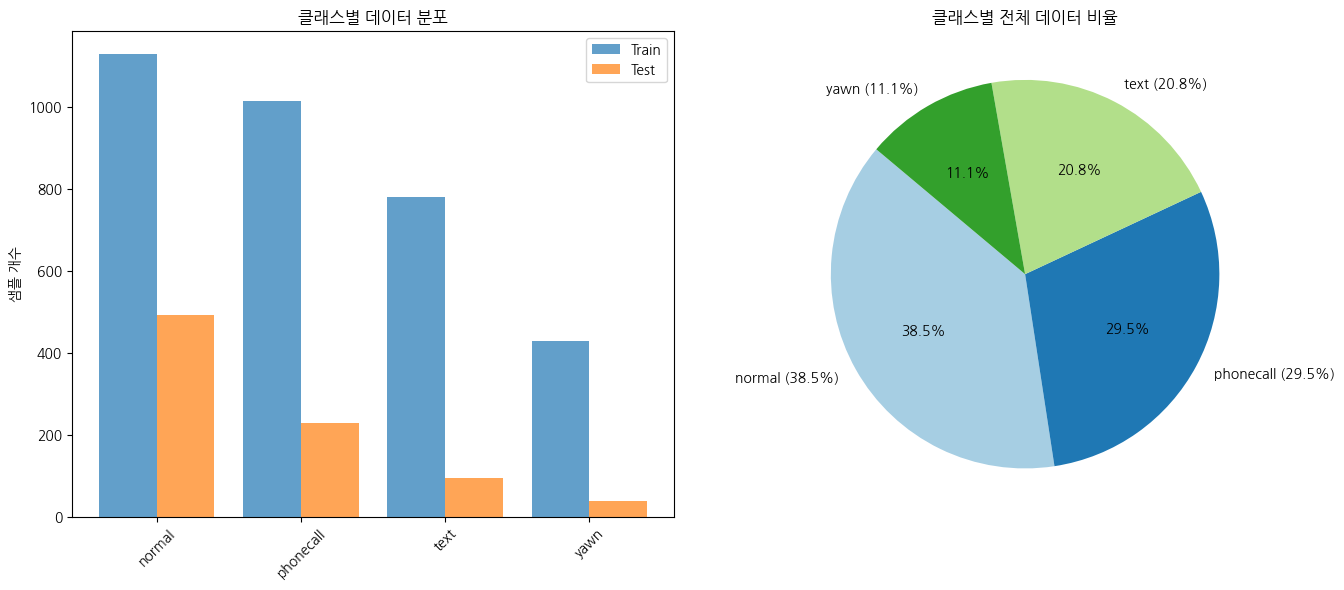

In [45]:
def visualize_data_distribution(train_labels, test_labels, label_mapping_inverse):
    """
    훈련/테스트 데이터의 레이블 분포를 시각화하는 함수.

    Args:
        train_labels (list or pd.Series): 훈련 데이터의 레이블.
        test_labels (list or pd.Series): 테스트 데이터의 레이블.
        label_mapping_inverse (dict): 정수형 레이블을 문자열로 매핑하는 딕셔너리.
    """
    # 레이블 개수 및 비율 계산
    train_label_counts = pd.Series(train_labels).value_counts()
    train_label_ratios = pd.Series(train_labels).value_counts(normalize=True) * 100

    test_label_counts = pd.Series(test_labels).value_counts()
    test_label_ratios = pd.Series(test_labels).value_counts(normalize=True) * 100

    # 클래스 이름 매핑
    class_names = [label_mapping_inverse[label] for label in train_label_counts.index]

    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # (왼쪽) Bar Chart - 클래스별 샘플 개수 비교
    x = np.arange(len(class_names))
    width = 0.4

    axes[0].bar(x - width / 2, train_label_counts.values, width, label="Train", alpha=0.7)
    axes[0].bar(x + width / 2, test_label_counts.values, width, label="Test", alpha=0.7)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(class_names, rotation=45)
    axes[0].set_ylabel("샘플 개수")
    axes[0].set_title("클래스별 데이터 분포")
    axes[0].legend()

    # (오른쪽) Pie Chart - 전체 데이터 비율
    total_counts = train_label_counts + test_label_counts
    total_ratios = total_counts / total_counts.sum() * 100

    axes[1].pie(
        total_counts,
        labels=[f"{class_names[i]} ({total_ratios[i]:.1f}%)" for i in range(len(class_names))],
        autopct="%1.1f%%",
        startangle=140,
        colors=plt.cm.Paired.colors,
    )
    axes[1].set_title("클래스별 전체 데이터 비율")

    plt.tight_layout()
    plt.show()

visualize_data_distribution(train_labels, test_labels, label_mapping_inverse)

### DataLoader

In [46]:
# DataLoader 설정
params = {
    "batch_size": config["batch_size"],
    "shuffle": True,
    "num_workers": 4,
    "pin_memory": True,
    "persistent_workers": True,
    "prefetch_factor": 2,
} if config["use_cuda"] else {}

In [47]:
test_dataset = TensorDataset(test_features, test_labels)
test_loader = DataLoader(test_dataset, **params)

for x_batch, y_batch in test_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # 한 배치만 확인

Batch Shape: torch.Size([32, 24, 5]) torch.Size([32])


In [48]:
# Train, Test 라벨별 개수 확인
labels = train_labels.to(torch.long)#  Long 타입으로 변환
counts = torch.bincount(labels)
print(counts)

labels = test_labels.to(torch.long)
counts = torch.bincount(labels)
print(counts)

tensor([1129, 1015,  780,  430])
tensor([493, 229,  96,  38])


## 1-3. LSTM 학습

In [49]:
# LSTM 모델 정의
class DecoderRNN(nn.Module):
    def __init__(self, config):
        super(DecoderRNN, self).__init__()

        self.RNN_input_size = config['feature_num']  # 특징 개수
        self.h_RNN_layers = config["RNN_hidden_layers"]
        self.h_RNN = config["RNN_hidden_nodes"]
        self.h_FC_dim = config["RNN_FC_dim"]
        self.drop_p = config["dropout_p"]
        self.num_classes = config["k"]

        self.LSTM = nn.LSTM(
            input_size=self.RNN_input_size,
            hidden_size=self.h_RNN,
            num_layers=self.h_RNN_layers,
            batch_first=True,
        )

        self.fc1 = nn.Linear(self.h_RNN, self.h_FC_dim)
        self.fc2 = nn.Linear(self.h_FC_dim, self.num_classes)
        self.dropout = nn.Dropout(p=self.drop_p)

    def forward(self, x_RNN):
        self.LSTM.flatten_parameters()
        RNN_out, _ = self.LSTM(x_RNN, None)

        # FC layers
        x = self.fc1(RNN_out[:, -1, :])  # 마지막 타임스텝a 사용
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x  # CrossEntropyLoss 사용 (Softmax 없음)

### optimizer

In [50]:
def get_optimizer(model, config):
    return optim.Adam(model.parameters(), lr=config["learning_rate"])
criterion = nn.CrossEntropyLoss()

### 학습률 감소 스케줄러 설정
Test Loss 기준
- factor: 0.5, 학습률 50% 감소
- verbose: True, 감소된 경우 로그 출력

In [51]:
def get_scheduler(optimizer, config):
    return optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=config["reduce_lr_factor"],
        patience=config["reduce_lr_patience"],
    )

### Early Stopping 설정

In [52]:
early_stopping_patience = config["early_stopping_patience"]
best_loss = np.inf
patience_counter = 0

## 학습 진행

- Mixed Precision Training 유지 (torch.cuda.amp.autocast() + GradScaler())
-  Gradient Clipping 추가 (torch.nn.utils.clip_grad_norm_()) → 폭발적인 기울기(Gradient Explosion) 방지
- 모델 저장 기능 추가 (torch.save()) → Best Loss 갱신 시 자동 저장
- 학습률 스케줄러 로깅 추가 → ReduceLROnPlateau가 작동했는지 확인 가능

In [53]:
def save_best_model(model, optimizer, epoch, best_loss, save_path):
    """Validation Loss가 가장 낮을 때만 모델을 저장하는 함수"""
    today_date = datetime.datetime.now().strftime("%Y-%m-%d")  # 날짜 가져오기
    model_filename = f"{save_path}/best_model_{today_date}.pth"  # 저장 파일명

    # 기존 최적 모델 삭제 (이전 모델 유지 안 함)
    if os.path.exists(model_filename):
        os.remove(model_filename)

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_loss': best_loss
    }, model_filename)

    print(f"💾 Best Model Updated! Saved at {model_filename} (Loss: {best_loss:.4f})")

def save_training_results(
        epoch_train_losses,
        epoch_train_scores,
        epoch_test_losses,
        epoch_test_scores,
        save_path="./",
        ):
    """
    학습 과정의 손실(loss)과 정확도(score)를 저장하는 함수
    """
    os.makedirs(save_path, exist_ok=True)

    np.save(
        os.path.join(save_path, "LSTM_epoch_training_losses.npy"),
        np.array(epoch_train_losses),
    )
    np.save(
        os.path.join(save_path, "LSTM_epoch_tsave_path, raining_scores.npy"),
        np.array(epoch_train_scores),
    )
    np.save(
        os.path.join(save_path, "LSTM_epoch_test_loss.npy"), np.array(epoch_test_losses)
    )
    np.save(
        os.path.join(save_path, "LSTM_epoch_test_score.npy"),
        np.array(epoch_test_scores),
    )

In [54]:
def ensure_directory_exists(path):
    """주어진 경로의 폴더가 없으면 생성하는 함수"""
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"📂 Directory created: {path}")

In [55]:
# ✅ 경로 자동 생성 (존재하지 않으면 생성)
ensure_directory_exists(os.path.dirname(config["model_save_path"]))  # 모델 저장 폴더
ensure_directory_exists(config["train_result_path"])  # 학습 결과 폴더

### epoch마다 validation data로 성능평가
- 다음 기술을 적용하는 기준: validation data loss
    - Early Stopping
    - 학습률 감소 스케줄러
    - 모델 저장 (Best Loss 갱신 시)

In [56]:
def print_label_distribution(labels, title="Label Distribution"):
    """텐서 형태의 labels를 이용해 라벨 분포를 출력하는 함수"""
    # 라벨별 개수 계산
    unique_labels, counts = torch.unique(labels, return_counts=True)

    # 분포 출력
    print(f"\n{title}:")
    for label, count in zip(unique_labels.tolist(), counts.tolist()):
        print(f"Label {label}: {count} samples ({count / len(labels) * 100:.2f}%)")

In [57]:
# Mixed Precision Training을 위한 GradScaler 설정
scaler = torch.amp.GradScaler()

# 학습 함수
def train(log_interval, model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    losses, scores = [], []
    total_samples = 0

    # tqdm을 사용하여 학습 진행률 표시
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']}", leave=True)

    for batch_idx, (X, y) in enumerate(progress_bar):
        X, y = X.to(device), y.to(device).long()
        total_samples += X.size(0)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type='cuda'):
            output = model(X)
            loss = criterion(output, y)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  #  Gradient Clipping
        scaler.step(optimizer)
        scaler.update()

        losses.append(loss.item())

        # 정확도 계산
        y_pred = torch.argmax(output, dim=1)
        acc = accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())
        scores.append(acc)

    avg_loss = sum(losses) / len(losses)
    avg_acc = sum(scores) / len(scores) * 100

    print(f"✅ Train Epoch {epoch+1} Finished - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.2f}%")

    return avg_loss, avg_acc  # 학습 Loss 및 Accuracy 반환

# 검증 함수
def validate(model, device, criterion, test_loader, epoch, model_save_path=None, optimizer=None):
    model.eval()
    losses, scores = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device).long()

            with torch.amp.autocast(device_type='cuda'):
                output = model(X)
                loss = criterion(output, y)

            losses.append(loss.item())

            # 정확도 계산
            y_pred = torch.argmax(output, dim=1)
            acc = accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())
            scores.append(acc)

    avg_loss = sum(losses) / len(losses)
    avg_acc = sum(scores) / len(scores) * 100

    print(f"✅ Validation Finished - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.2f}%")
    # 모델 저장 기능(옵셔널)
    if model_save_path and optimizer:
        save_best_model(model, optimizer, epoch, best_loss, config["model_save_path"])

    return avg_loss, avg_acc  # 검증 Loss 및 Accuracy 반환

In [58]:
def save_training_results(fold, epoch, train_loss, train_acc,
                        val_loss, val_acc, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    file_path = f'{save_dir}/training_results.csv'

    results = {
        'fold': fold,
        'epoch': epoch+1,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc
    }

    df = pd.DataFrame([results])
    header = not os.path.exists(file_path)

    df.to_csv(file_path, mode='a',
             header=header, index=False)

def save_best_model(model, optimizer, epoch, loss, save_dir, fold):
    os.makedirs(save_dir, exist_ok=True)
    path = f"{save_dir}/best_model_fold{fold}.pt"

    torch.save({
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'loss': loss,
    }, path)

In [59]:
def plot_confusion_matrix(y_true, y_pred, fold, save_dir, label_mapping):
    """Confusion Matrix를 그려 저장하는 함수"""
    # 클래스 이름 및 순서 정의
    class_names = list(label_mapping.keys())
    class_indices = list(label_mapping.values())

    # Confusion Matrix 계산
    cm = confusion_matrix(y_true, y_pred, labels=class_indices)

    # 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f'Fold {fold + 1} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # 저장 경로 생성
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f'fold{fold + 1}_cm.png')
    plt.savefig(save_path)
    plt.close()


def plot_loss_accuracy(train_losses, val_losses, train_accs, val_accs, fold, save_dir):
    """Loss와 Accuracy 그래프를 그려 저장하는 함수"""
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title(f'Fold {fold + 1} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # 저장 경로 생성
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f'fold{fold + 1}_loss_acc.png')
    plt.savefig(save_path)
    plt.close()

In [60]:
from sklearn.model_selection import StratifiedGroupKFold

def train_and_validate_with_cv(model, features, labels, person_groups, config):
    sgkf = StratifiedGroupKFold(n_splits=config['cv_folds'],
                              shuffle=True,
                              random_state=config['seed'])
    all_results = []

    for fold, (train_idx, val_idx) in enumerate(sgkf.split(features, labels, person_groups)):
        epoch_train_losses, epoch_train_scores = [], []
        epoch_val_losses, epoch_val_scores = [], []


        # 데이터 분할
        train_features, train_labels = features[train_idx], labels[train_idx]
        val_features, val_labels = features[val_idx], labels[val_idx]

        # 라벨 분포 출력
        print(f"\n{'='*40}")
        print(f"🚀 Fold {fold+1}/{config['cv_folds']}")
        print(f"{'='*40}")

        print_label_distribution(train_labels, title="Train Set")
        print_label_distribution(val_labels, title="Validation Set")

        # DataLoader 생성
        train_dataset = TensorDataset(train_features, train_labels)
        val_dataset = TensorDataset(val_features, val_labels)
        train_loader = DataLoader(train_dataset, **params)
        val_loader = DataLoader(val_dataset, **params)

        # 모델 초기화
        model.to(config["device"])
        optimizer = get_optimizer(model, config)
        scheduler = get_scheduler(optimizer, config)
        early_stopping_patience = config["early_stopping_patience"]
        best_loss = np.inf
        early_stopping_patience_counter = 0
        best_model = None

        for epoch in range(config['epochs']):
            # 학습 단계
            epoch_train_loss, epoch_train_score = train(
                config["log_interval"], model, config["device"], train_loader, optimizer, criterion, epoch
            )

            # 검증 단계
            epoch_val_loss, epoch_val_score = validate(
                model, config["device"], criterion, val_loader, epoch
            )

            epoch_train_losses.append(epoch_train_loss)
            epoch_train_scores.append(epoch_train_score)
            epoch_val_losses.append(epoch_val_loss)
            epoch_val_scores.append(epoch_val_score)

            # 학습률 감소 적용
            scheduler.step(epoch_val_loss)

            # Early Stopping 체크
            if epoch_val_loss < best_loss:
                best_loss = epoch_val_loss
                early_stopping_patience_counter = 0  # 개선되었으므로 patience 초기화

                best_model = model
                save_best_model(model, optimizer, epoch, best_loss, config["model_save_path"], fold + 1)
                print(f"💾 Model Saved! New Best Loss: {best_loss:.4f}")
            else:
                early_stopping_patience_counter += 1
                print(f"⏳ Early stopping 대기 카운트: {early_stopping_patience_counter}/{config['early_stopping_patience']}")

            # 설정된 patience 횟수만큼 개선되지 않으면 학습 중단
            if early_stopping_patience_counter >= config["early_stopping_patience"]:
                print("⏹️ Early stopping 적용됨. 학습 종료.")
                break  # 학습 중단


            # Save results
            save_training_results(
                fold, epoch, epoch_train_loss, epoch_train_score,
                epoch_val_loss, epoch_val_score, config['train_result_path']
            )

        # Fold 종료 후 Confusion Matrix 및 그래프 저장
        val_preds = []
        val_targets = []
        best_model.eval()
        train_dataset_ = TensorDataset(features, labels)
        train_loader_ = DataLoader(train_dataset, **params)
        with torch.no_grad():
            for X, y in train_loader_:
                X, y = X.to(config["device"]), y.to(config["device"])
                output = model(X)
                val_preds.extend(torch.argmax(output, dim=1).cpu().numpy())
                val_targets.extend(y.cpu().numpy())

        # Confusion Matrix 저장
        plot_confusion_matrix(val_targets, val_preds, fold, config['train_result_path'], label_mapping)

        # Loss 및 Accuracy 그래프 저장
        plot_loss_accuracy(epoch_train_losses, epoch_val_losses,
                          epoch_train_scores, epoch_val_scores,
                          fold, config['train_result_path'])

    print("\n🎉 Training Complete!")
    return all_results

In [61]:
model = DecoderRNN(config)

epoch_train_losses, epoch_train_scores, epoch_test_losses, epoch_test_scores = train_and_validate_with_cv(model, train_features, train_labels, train_person_ids, config)
# RuntimeError: DataLoader worker -> dataloader 재실행


🚀 Fold 1/3

Train Set:
Label 0.0: 732 samples (33.17%)
Label 1.0: 671 samples (30.40%)
Label 2.0: 524 samples (23.74%)
Label 3.0: 280 samples (12.69%)

Validation Set:
Label 0.0: 397 samples (34.61%)
Label 1.0: 344 samples (29.99%)
Label 2.0: 256 samples (22.32%)
Label 3.0: 150 samples (13.08%)


Epoch 1/100: 100%|██████████| 69/69 [00:01<00:00, 54.28it/s]

✅ Train Epoch 1 Finished - Avg Loss: 1.3768, Avg Acc: 33.17%


✅ Validation Finished - Avg Loss: 1.3672, Avg Acc: 34.57%
💾 Model Saved! New Best Loss: 1.3672


Epoch 2/100: 100%|██████████| 69/69 [00:00<00:00, 72.32it/s]


✅ Train Epoch 2 Finished - Avg Loss: 1.3621, Avg Acc: 33.16%
✅ Validation Finished - Avg Loss: 1.3528, Avg Acc: 34.67%
💾 Model Saved! New Best Loss: 1.3528


Epoch 3/100: 100%|██████████| 69/69 [00:00<00:00, 73.54it/s]


✅ Train Epoch 3 Finished - Avg Loss: 1.3464, Avg Acc: 33.17%
✅ Validation Finished - Avg Loss: 1.3365, Avg Acc: 34.64%
💾 Model Saved! New Best Loss: 1.3365


Epoch 4/100: 100%|██████████| 69/69 [00:01<00:00, 65.37it/s]


✅ Train Epoch 4 Finished - Avg Loss: 1.3335, Avg Acc: 33.17%
✅ Validation Finished - Avg Loss: 1.3256, Avg Acc: 34.61%
💾 Model Saved! New Best Loss: 1.3256


Epoch 5/100: 100%|██████████| 69/69 [00:01<00:00, 51.83it/s]


✅ Train Epoch 5 Finished - Avg Loss: 1.3253, Avg Acc: 33.89%
✅ Validation Finished - Avg Loss: 1.3210, Avg Acc: 34.62%
💾 Model Saved! New Best Loss: 1.3210


Epoch 6/100: 100%|██████████| 69/69 [00:01<00:00, 56.64it/s]


✅ Train Epoch 6 Finished - Avg Loss: 1.3188, Avg Acc: 38.75%
✅ Validation Finished - Avg Loss: 1.3131, Avg Acc: 58.88%
💾 Model Saved! New Best Loss: 1.3131


Epoch 7/100: 100%|██████████| 69/69 [00:00<00:00, 73.08it/s]


✅ Train Epoch 7 Finished - Avg Loss: 1.3042, Avg Acc: 42.18%
✅ Validation Finished - Avg Loss: 1.2849, Avg Acc: 49.86%
💾 Model Saved! New Best Loss: 1.2849


Epoch 8/100: 100%|██████████| 69/69 [00:00<00:00, 74.87it/s]


✅ Train Epoch 8 Finished - Avg Loss: 1.2202, Avg Acc: 49.89%
✅ Validation Finished - Avg Loss: 1.1150, Avg Acc: 53.39%
💾 Model Saved! New Best Loss: 1.1150


Epoch 9/100: 100%|██████████| 69/69 [00:00<00:00, 76.16it/s]


✅ Train Epoch 9 Finished - Avg Loss: 1.1109, Avg Acc: 55.77%
✅ Validation Finished - Avg Loss: 1.0555, Avg Acc: 61.40%
💾 Model Saved! New Best Loss: 1.0555


Epoch 10/100: 100%|██████████| 69/69 [00:00<00:00, 74.26it/s]


✅ Train Epoch 10 Finished - Avg Loss: 1.0665, Avg Acc: 57.41%
✅ Validation Finished - Avg Loss: 0.9951, Avg Acc: 62.99%
💾 Model Saved! New Best Loss: 0.9951


Epoch 11/100: 100%|██████████| 69/69 [00:00<00:00, 75.89it/s]


✅ Train Epoch 11 Finished - Avg Loss: 1.0136, Avg Acc: 56.86%
✅ Validation Finished - Avg Loss: 0.9253, Avg Acc: 63.67%
💾 Model Saved! New Best Loss: 0.9253


Epoch 12/100: 100%|██████████| 69/69 [00:00<00:00, 75.15it/s]


✅ Train Epoch 12 Finished - Avg Loss: 0.9749, Avg Acc: 58.32%
✅ Validation Finished - Avg Loss: 0.8917, Avg Acc: 65.72%
💾 Model Saved! New Best Loss: 0.8917


Epoch 13/100: 100%|██████████| 69/69 [00:00<00:00, 69.30it/s]


✅ Train Epoch 13 Finished - Avg Loss: 0.9596, Avg Acc: 59.80%
✅ Validation Finished - Avg Loss: 0.8637, Avg Acc: 66.45%
💾 Model Saved! New Best Loss: 0.8637


Epoch 14/100: 100%|██████████| 69/69 [00:01<00:00, 50.70it/s]


✅ Train Epoch 14 Finished - Avg Loss: 0.9480, Avg Acc: 59.81%
✅ Validation Finished - Avg Loss: 0.8540, Avg Acc: 66.61%
💾 Model Saved! New Best Loss: 0.8540


Epoch 15/100: 100%|██████████| 69/69 [00:01<00:00, 58.51it/s]


✅ Train Epoch 15 Finished - Avg Loss: 0.9440, Avg Acc: 60.17%
✅ Validation Finished - Avg Loss: 0.8440, Avg Acc: 66.73%
💾 Model Saved! New Best Loss: 0.8440


Epoch 16/100: 100%|██████████| 69/69 [00:00<00:00, 74.30it/s]


✅ Train Epoch 16 Finished - Avg Loss: 0.9314, Avg Acc: 60.67%
✅ Validation Finished - Avg Loss: 0.8339, Avg Acc: 66.97%
💾 Model Saved! New Best Loss: 0.8339


Epoch 17/100: 100%|██████████| 69/69 [00:00<00:00, 74.85it/s]


✅ Train Epoch 17 Finished - Avg Loss: 0.9305, Avg Acc: 60.49%
✅ Validation Finished - Avg Loss: 0.8328, Avg Acc: 67.37%
💾 Model Saved! New Best Loss: 0.8328


Epoch 18/100: 100%|██████████| 69/69 [00:00<00:00, 74.01it/s]


✅ Train Epoch 18 Finished - Avg Loss: 0.9260, Avg Acc: 60.89%
✅ Validation Finished - Avg Loss: 0.8185, Avg Acc: 67.38%
💾 Model Saved! New Best Loss: 0.8185


Epoch 19/100: 100%|██████████| 69/69 [00:00<00:00, 71.70it/s]


✅ Train Epoch 19 Finished - Avg Loss: 0.9188, Avg Acc: 60.94%
✅ Validation Finished - Avg Loss: 0.8131, Avg Acc: 67.79%
💾 Model Saved! New Best Loss: 0.8131


Epoch 20/100: 100%|██████████| 69/69 [00:00<00:00, 73.51it/s]


✅ Train Epoch 20 Finished - Avg Loss: 0.9232, Avg Acc: 60.67%
✅ Validation Finished - Avg Loss: 0.8112, Avg Acc: 68.19%
💾 Model Saved! New Best Loss: 0.8112


Epoch 21/100: 100%|██████████| 69/69 [00:01<00:00, 63.26it/s]


✅ Train Epoch 21 Finished - Avg Loss: 0.9162, Avg Acc: 61.17%
✅ Validation Finished - Avg Loss: 0.8119, Avg Acc: 68.22%
⏳ Early stopping 대기 카운트: 1/100


Epoch 22/100: 100%|██████████| 69/69 [00:01<00:00, 61.99it/s]


✅ Train Epoch 22 Finished - Avg Loss: 0.9150, Avg Acc: 61.26%
✅ Validation Finished - Avg Loss: 0.8023, Avg Acc: 68.26%
💾 Model Saved! New Best Loss: 0.8023


Epoch 23/100: 100%|██████████| 69/69 [00:01<00:00, 51.15it/s]


✅ Train Epoch 23 Finished - Avg Loss: 0.9110, Avg Acc: 61.16%
✅ Validation Finished - Avg Loss: 0.8005, Avg Acc: 67.56%
💾 Model Saved! New Best Loss: 0.8005


Epoch 24/100: 100%|██████████| 69/69 [00:01<00:00, 63.30it/s]


✅ Train Epoch 24 Finished - Avg Loss: 0.9069, Avg Acc: 61.49%
✅ Validation Finished - Avg Loss: 0.7969, Avg Acc: 67.98%
💾 Model Saved! New Best Loss: 0.7969


Epoch 25/100: 100%|██████████| 69/69 [00:00<00:00, 73.97it/s]


✅ Train Epoch 25 Finished - Avg Loss: 0.9048, Avg Acc: 61.58%
✅ Validation Finished - Avg Loss: 0.7957, Avg Acc: 67.77%
💾 Model Saved! New Best Loss: 0.7957


Epoch 26/100: 100%|██████████| 69/69 [00:00<00:00, 77.25it/s]


✅ Train Epoch 26 Finished - Avg Loss: 0.9012, Avg Acc: 61.81%
✅ Validation Finished - Avg Loss: 0.8051, Avg Acc: 67.78%
⏳ Early stopping 대기 카운트: 1/100


Epoch 27/100: 100%|██████████| 69/69 [00:00<00:00, 76.33it/s]


✅ Train Epoch 27 Finished - Avg Loss: 0.9039, Avg Acc: 61.44%
✅ Validation Finished - Avg Loss: 0.7925, Avg Acc: 67.58%
💾 Model Saved! New Best Loss: 0.7925


Epoch 28/100: 100%|██████████| 69/69 [00:00<00:00, 75.69it/s]


✅ Train Epoch 28 Finished - Avg Loss: 0.9102, Avg Acc: 60.98%
✅ Validation Finished - Avg Loss: 0.8028, Avg Acc: 67.41%
⏳ Early stopping 대기 카운트: 1/100


Epoch 29/100: 100%|██████████| 69/69 [00:00<00:00, 77.08it/s]


✅ Train Epoch 29 Finished - Avg Loss: 0.8987, Avg Acc: 61.44%
✅ Validation Finished - Avg Loss: 0.7898, Avg Acc: 67.91%
💾 Model Saved! New Best Loss: 0.7898


Epoch 30/100: 100%|██████████| 69/69 [00:00<00:00, 75.19it/s]


✅ Train Epoch 30 Finished - Avg Loss: 0.8989, Avg Acc: 61.31%
✅ Validation Finished - Avg Loss: 0.7907, Avg Acc: 67.77%
⏳ Early stopping 대기 카운트: 1/100


Epoch 31/100: 100%|██████████| 69/69 [00:00<00:00, 75.58it/s]


✅ Train Epoch 31 Finished - Avg Loss: 0.8948, Avg Acc: 61.58%
✅ Validation Finished - Avg Loss: 0.7850, Avg Acc: 67.63%
💾 Model Saved! New Best Loss: 0.7850


Epoch 32/100: 100%|██████████| 69/69 [00:01<00:00, 54.24it/s]


✅ Train Epoch 32 Finished - Avg Loss: 0.8947, Avg Acc: 62.07%
✅ Validation Finished - Avg Loss: 0.7844, Avg Acc: 67.51%
💾 Model Saved! New Best Loss: 0.7844


Epoch 33/100: 100%|██████████| 69/69 [00:01<00:00, 51.98it/s]


✅ Train Epoch 33 Finished - Avg Loss: 0.8923, Avg Acc: 61.44%
✅ Validation Finished - Avg Loss: 0.7845, Avg Acc: 67.81%
⏳ Early stopping 대기 카운트: 1/100


Epoch 34/100: 100%|██████████| 69/69 [00:00<00:00, 76.71it/s]


✅ Train Epoch 34 Finished - Avg Loss: 0.8917, Avg Acc: 61.84%
✅ Validation Finished - Avg Loss: 0.7973, Avg Acc: 67.51%
⏳ Early stopping 대기 카운트: 2/100


Epoch 35/100: 100%|██████████| 69/69 [00:00<00:00, 78.19it/s]


✅ Train Epoch 35 Finished - Avg Loss: 0.8898, Avg Acc: 62.17%
✅ Validation Finished - Avg Loss: 0.7768, Avg Acc: 68.02%
💾 Model Saved! New Best Loss: 0.7768


Epoch 36/100: 100%|██████████| 69/69 [00:00<00:00, 78.79it/s]


✅ Train Epoch 36 Finished - Avg Loss: 0.8897, Avg Acc: 62.07%
✅ Validation Finished - Avg Loss: 0.7744, Avg Acc: 68.03%
💾 Model Saved! New Best Loss: 0.7744


Epoch 37/100: 100%|██████████| 69/69 [00:00<00:00, 75.61it/s]


✅ Train Epoch 37 Finished - Avg Loss: 0.8873, Avg Acc: 62.03%
✅ Validation Finished - Avg Loss: 0.7928, Avg Acc: 67.00%
⏳ Early stopping 대기 카운트: 1/100


Epoch 38/100: 100%|██████████| 69/69 [00:00<00:00, 76.35it/s]


✅ Train Epoch 38 Finished - Avg Loss: 0.8894, Avg Acc: 61.85%
✅ Validation Finished - Avg Loss: 0.7769, Avg Acc: 68.36%
⏳ Early stopping 대기 카운트: 2/100


Epoch 39/100: 100%|██████████| 69/69 [00:00<00:00, 75.77it/s]


✅ Train Epoch 39 Finished - Avg Loss: 0.8860, Avg Acc: 61.98%
✅ Validation Finished - Avg Loss: 0.7741, Avg Acc: 67.88%
💾 Model Saved! New Best Loss: 0.7741


Epoch 40/100: 100%|██████████| 69/69 [00:00<00:00, 76.65it/s]


✅ Train Epoch 40 Finished - Avg Loss: 0.8857, Avg Acc: 61.76%
✅ Validation Finished - Avg Loss: 0.7822, Avg Acc: 67.81%
⏳ Early stopping 대기 카운트: 1/100


Epoch 41/100: 100%|██████████| 69/69 [00:00<00:00, 76.20it/s]


✅ Train Epoch 41 Finished - Avg Loss: 0.8786, Avg Acc: 62.76%
✅ Validation Finished - Avg Loss: 0.7677, Avg Acc: 68.10%
💾 Model Saved! New Best Loss: 0.7677


Epoch 42/100: 100%|██████████| 69/69 [00:01<00:00, 51.36it/s]


✅ Train Epoch 42 Finished - Avg Loss: 0.8806, Avg Acc: 61.84%
✅ Validation Finished - Avg Loss: 0.7888, Avg Acc: 67.74%
⏳ Early stopping 대기 카운트: 1/100


Epoch 43/100: 100%|██████████| 69/69 [00:01<00:00, 52.79it/s]


✅ Train Epoch 43 Finished - Avg Loss: 0.8820, Avg Acc: 62.30%
✅ Validation Finished - Avg Loss: 0.7658, Avg Acc: 67.91%
💾 Model Saved! New Best Loss: 0.7658


Epoch 44/100: 100%|██████████| 69/69 [00:00<00:00, 69.40it/s]


✅ Train Epoch 44 Finished - Avg Loss: 0.8768, Avg Acc: 62.48%
✅ Validation Finished - Avg Loss: 0.7714, Avg Acc: 68.12%
⏳ Early stopping 대기 카운트: 1/100


Epoch 45/100: 100%|██████████| 69/69 [00:00<00:00, 75.17it/s]


✅ Train Epoch 45 Finished - Avg Loss: 0.8794, Avg Acc: 61.44%
✅ Validation Finished - Avg Loss: 0.7603, Avg Acc: 68.31%
💾 Model Saved! New Best Loss: 0.7603


Epoch 46/100: 100%|██████████| 69/69 [00:00<00:00, 79.06it/s]


✅ Train Epoch 46 Finished - Avg Loss: 0.8746, Avg Acc: 61.76%
✅ Validation Finished - Avg Loss: 0.7645, Avg Acc: 68.27%
⏳ Early stopping 대기 카운트: 1/100


Epoch 47/100: 100%|██████████| 69/69 [00:00<00:00, 78.39it/s]


✅ Train Epoch 47 Finished - Avg Loss: 0.8721, Avg Acc: 62.71%
✅ Validation Finished - Avg Loss: 0.7679, Avg Acc: 67.34%
⏳ Early stopping 대기 카운트: 2/100


Epoch 48/100: 100%|██████████| 69/69 [00:00<00:00, 76.63it/s]


✅ Train Epoch 48 Finished - Avg Loss: 0.8721, Avg Acc: 62.30%
✅ Validation Finished - Avg Loss: 0.7787, Avg Acc: 67.20%
⏳ Early stopping 대기 카운트: 3/100


Epoch 49/100: 100%|██████████| 69/69 [00:00<00:00, 77.16it/s]


✅ Train Epoch 49 Finished - Avg Loss: 0.8710, Avg Acc: 61.99%
✅ Validation Finished - Avg Loss: 0.7648, Avg Acc: 67.75%
⏳ Early stopping 대기 카운트: 4/100


Epoch 50/100: 100%|██████████| 69/69 [00:00<00:00, 73.64it/s]


✅ Train Epoch 50 Finished - Avg Loss: 0.8703, Avg Acc: 62.12%
✅ Validation Finished - Avg Loss: 0.7619, Avg Acc: 67.89%
⏳ Early stopping 대기 카운트: 5/100


Epoch 51/100: 100%|██████████| 69/69 [00:01<00:00, 64.84it/s]


✅ Train Epoch 51 Finished - Avg Loss: 0.8678, Avg Acc: 62.48%
✅ Validation Finished - Avg Loss: 0.7490, Avg Acc: 68.40%
💾 Model Saved! New Best Loss: 0.7490


Epoch 52/100: 100%|██████████| 69/69 [00:01<00:00, 62.55it/s]


✅ Train Epoch 52 Finished - Avg Loss: 0.8650, Avg Acc: 61.98%
✅ Validation Finished - Avg Loss: 0.7483, Avg Acc: 68.34%
💾 Model Saved! New Best Loss: 0.7483


Epoch 53/100: 100%|██████████| 69/69 [00:01<00:00, 52.03it/s]


✅ Train Epoch 53 Finished - Avg Loss: 0.8589, Avg Acc: 63.07%
✅ Validation Finished - Avg Loss: 0.7530, Avg Acc: 68.19%
⏳ Early stopping 대기 카운트: 1/100


Epoch 54/100: 100%|██████████| 69/69 [00:01<00:00, 57.82it/s]


✅ Train Epoch 54 Finished - Avg Loss: 0.8590, Avg Acc: 61.94%
✅ Validation Finished - Avg Loss: 0.7498, Avg Acc: 68.01%
⏳ Early stopping 대기 카운트: 2/100


Epoch 55/100: 100%|██████████| 69/69 [00:00<00:00, 77.75it/s]


✅ Train Epoch 55 Finished - Avg Loss: 0.8565, Avg Acc: 62.07%
✅ Validation Finished - Avg Loss: 0.7507, Avg Acc: 68.27%
⏳ Early stopping 대기 카운트: 3/100


Epoch 56/100: 100%|██████████| 69/69 [00:00<00:00, 77.65it/s]


✅ Train Epoch 56 Finished - Avg Loss: 0.8530, Avg Acc: 62.80%
✅ Validation Finished - Avg Loss: 0.7426, Avg Acc: 68.27%
💾 Model Saved! New Best Loss: 0.7426


Epoch 57/100: 100%|██████████| 69/69 [00:00<00:00, 76.23it/s]


✅ Train Epoch 57 Finished - Avg Loss: 0.8525, Avg Acc: 62.62%
✅ Validation Finished - Avg Loss: 0.7384, Avg Acc: 68.52%
💾 Model Saved! New Best Loss: 0.7384


Epoch 58/100: 100%|██████████| 69/69 [00:00<00:00, 77.33it/s]


✅ Train Epoch 58 Finished - Avg Loss: 0.8524, Avg Acc: 62.07%
✅ Validation Finished - Avg Loss: 0.7466, Avg Acc: 67.93%
⏳ Early stopping 대기 카운트: 1/100


Epoch 59/100: 100%|██████████| 69/69 [00:00<00:00, 74.70it/s]


✅ Train Epoch 59 Finished - Avg Loss: 0.8473, Avg Acc: 62.39%
✅ Validation Finished - Avg Loss: 0.7298, Avg Acc: 68.95%
💾 Model Saved! New Best Loss: 0.7298


Epoch 60/100: 100%|██████████| 69/69 [00:00<00:00, 76.64it/s]


✅ Train Epoch 60 Finished - Avg Loss: 0.8400, Avg Acc: 62.94%
✅ Validation Finished - Avg Loss: 0.7234, Avg Acc: 69.28%
💾 Model Saved! New Best Loss: 0.7234


Epoch 61/100: 100%|██████████| 69/69 [00:00<00:00, 76.90it/s]


✅ Train Epoch 61 Finished - Avg Loss: 0.8369, Avg Acc: 62.98%
✅ Validation Finished - Avg Loss: 0.7232, Avg Acc: 68.85%
💾 Model Saved! New Best Loss: 0.7232


Epoch 62/100: 100%|██████████| 69/69 [00:01<00:00, 66.48it/s]


✅ Train Epoch 62 Finished - Avg Loss: 0.8305, Avg Acc: 63.03%
✅ Validation Finished - Avg Loss: 0.7236, Avg Acc: 69.17%
⏳ Early stopping 대기 카운트: 1/100


Epoch 63/100: 100%|██████████| 69/69 [00:01<00:00, 51.78it/s]


✅ Train Epoch 63 Finished - Avg Loss: 0.8296, Avg Acc: 62.98%
✅ Validation Finished - Avg Loss: 0.7244, Avg Acc: 69.07%
⏳ Early stopping 대기 카운트: 2/100


Epoch 64/100: 100%|██████████| 69/69 [00:01<00:00, 50.39it/s]


✅ Train Epoch 64 Finished - Avg Loss: 0.8283, Avg Acc: 62.43%
✅ Validation Finished - Avg Loss: 0.7165, Avg Acc: 69.16%
💾 Model Saved! New Best Loss: 0.7165


Epoch 65/100: 100%|██████████| 69/69 [00:00<00:00, 77.19it/s]


✅ Train Epoch 65 Finished - Avg Loss: 0.8243, Avg Acc: 63.71%
✅ Validation Finished - Avg Loss: 0.7135, Avg Acc: 69.32%
💾 Model Saved! New Best Loss: 0.7135


Epoch 66/100: 100%|██████████| 69/69 [00:00<00:00, 76.59it/s]


✅ Train Epoch 66 Finished - Avg Loss: 0.8247, Avg Acc: 62.44%
✅ Validation Finished - Avg Loss: 0.7044, Avg Acc: 69.73%
💾 Model Saved! New Best Loss: 0.7044


Epoch 67/100: 100%|██████████| 69/69 [00:00<00:00, 75.54it/s]


✅ Train Epoch 67 Finished - Avg Loss: 0.8233, Avg Acc: 63.48%
✅ Validation Finished - Avg Loss: 0.7021, Avg Acc: 69.88%
💾 Model Saved! New Best Loss: 0.7021


Epoch 68/100: 100%|██████████| 69/69 [00:00<00:00, 75.21it/s]


✅ Train Epoch 68 Finished - Avg Loss: 0.8244, Avg Acc: 63.21%
✅ Validation Finished - Avg Loss: 0.7060, Avg Acc: 69.82%
⏳ Early stopping 대기 카운트: 1/100


Epoch 69/100: 100%|██████████| 69/69 [00:00<00:00, 77.25it/s]


✅ Train Epoch 69 Finished - Avg Loss: 0.8190, Avg Acc: 62.66%
✅ Validation Finished - Avg Loss: 0.7042, Avg Acc: 69.73%
⏳ Early stopping 대기 카운트: 2/100


Epoch 70/100: 100%|██████████| 69/69 [00:00<00:00, 78.59it/s]


✅ Train Epoch 70 Finished - Avg Loss: 0.8162, Avg Acc: 64.17%
✅ Validation Finished - Avg Loss: 0.6979, Avg Acc: 70.10%
💾 Model Saved! New Best Loss: 0.6979


Epoch 71/100: 100%|██████████| 69/69 [00:00<00:00, 77.23it/s]


✅ Train Epoch 71 Finished - Avg Loss: 0.8135, Avg Acc: 63.39%
✅ Validation Finished - Avg Loss: 0.6952, Avg Acc: 70.08%
💾 Model Saved! New Best Loss: 0.6952


Epoch 72/100: 100%|██████████| 69/69 [00:01<00:00, 63.70it/s]


✅ Train Epoch 72 Finished - Avg Loss: 0.8182, Avg Acc: 62.71%
✅ Validation Finished - Avg Loss: 0.6928, Avg Acc: 70.69%
💾 Model Saved! New Best Loss: 0.6928


Epoch 73/100: 100%|██████████| 69/69 [00:01<00:00, 53.93it/s]


✅ Train Epoch 73 Finished - Avg Loss: 0.8156, Avg Acc: 63.11%
✅ Validation Finished - Avg Loss: 0.6939, Avg Acc: 70.27%
⏳ Early stopping 대기 카운트: 1/100


Epoch 74/100: 100%|██████████| 69/69 [00:01<00:00, 57.54it/s]


✅ Train Epoch 74 Finished - Avg Loss: 0.8107, Avg Acc: 63.93%
✅ Validation Finished - Avg Loss: 0.6905, Avg Acc: 70.79%
💾 Model Saved! New Best Loss: 0.6905


Epoch 75/100: 100%|██████████| 69/69 [00:00<00:00, 76.25it/s]


✅ Train Epoch 75 Finished - Avg Loss: 0.8121, Avg Acc: 62.99%
✅ Validation Finished - Avg Loss: 0.6932, Avg Acc: 70.53%
⏳ Early stopping 대기 카운트: 1/100


Epoch 76/100: 100%|██████████| 69/69 [00:00<00:00, 77.47it/s]


✅ Train Epoch 76 Finished - Avg Loss: 0.8131, Avg Acc: 63.12%
✅ Validation Finished - Avg Loss: 0.6901, Avg Acc: 70.60%
💾 Model Saved! New Best Loss: 0.6901


Epoch 77/100: 100%|██████████| 69/69 [00:00<00:00, 77.64it/s]


✅ Train Epoch 77 Finished - Avg Loss: 0.8071, Avg Acc: 63.53%
✅ Validation Finished - Avg Loss: 0.6884, Avg Acc: 70.33%
💾 Model Saved! New Best Loss: 0.6884


Epoch 78/100: 100%|██████████| 69/69 [00:00<00:00, 76.81it/s]


✅ Train Epoch 78 Finished - Avg Loss: 0.8128, Avg Acc: 63.21%
✅ Validation Finished - Avg Loss: 0.6853, Avg Acc: 70.23%
💾 Model Saved! New Best Loss: 0.6853


Epoch 79/100: 100%|██████████| 69/69 [00:00<00:00, 77.47it/s]


✅ Train Epoch 79 Finished - Avg Loss: 0.8101, Avg Acc: 63.07%
✅ Validation Finished - Avg Loss: 0.6840, Avg Acc: 70.79%
💾 Model Saved! New Best Loss: 0.6840


Epoch 80/100: 100%|██████████| 69/69 [00:00<00:00, 79.01it/s]


✅ Train Epoch 80 Finished - Avg Loss: 0.8054, Avg Acc: 63.39%
✅ Validation Finished - Avg Loss: 0.6906, Avg Acc: 69.59%
⏳ Early stopping 대기 카운트: 1/100


Epoch 81/100: 100%|██████████| 69/69 [00:00<00:00, 78.44it/s]


✅ Train Epoch 81 Finished - Avg Loss: 0.8052, Avg Acc: 63.30%
✅ Validation Finished - Avg Loss: 0.6937, Avg Acc: 70.97%
⏳ Early stopping 대기 카운트: 2/100


Epoch 82/100: 100%|██████████| 69/69 [00:01<00:00, 59.73it/s]


✅ Train Epoch 82 Finished - Avg Loss: 0.8019, Avg Acc: 63.53%
✅ Validation Finished - Avg Loss: 0.6785, Avg Acc: 70.95%
💾 Model Saved! New Best Loss: 0.6785


Epoch 83/100: 100%|██████████| 69/69 [00:01<00:00, 54.34it/s]


✅ Train Epoch 83 Finished - Avg Loss: 0.7949, Avg Acc: 63.75%
✅ Validation Finished - Avg Loss: 0.6755, Avg Acc: 70.63%
💾 Model Saved! New Best Loss: 0.6755


Epoch 84/100: 100%|██████████| 69/69 [00:01<00:00, 67.01it/s]


✅ Train Epoch 84 Finished - Avg Loss: 0.7948, Avg Acc: 63.67%
✅ Validation Finished - Avg Loss: 0.6743, Avg Acc: 70.81%
💾 Model Saved! New Best Loss: 0.6743


Epoch 85/100: 100%|██████████| 69/69 [00:00<00:00, 76.42it/s]


✅ Train Epoch 85 Finished - Avg Loss: 0.7887, Avg Acc: 63.71%
✅ Validation Finished - Avg Loss: 0.6698, Avg Acc: 70.36%
💾 Model Saved! New Best Loss: 0.6698


Epoch 86/100: 100%|██████████| 69/69 [00:00<00:00, 69.53it/s]


✅ Train Epoch 86 Finished - Avg Loss: 0.7882, Avg Acc: 64.07%
✅ Validation Finished - Avg Loss: 0.6708, Avg Acc: 69.83%
⏳ Early stopping 대기 카운트: 1/100


Epoch 87/100: 100%|██████████| 69/69 [00:00<00:00, 75.54it/s]


✅ Train Epoch 87 Finished - Avg Loss: 0.7864, Avg Acc: 64.11%
✅ Validation Finished - Avg Loss: 0.6611, Avg Acc: 71.64%
💾 Model Saved! New Best Loss: 0.6611


Epoch 88/100: 100%|██████████| 69/69 [00:00<00:00, 75.46it/s]


✅ Train Epoch 88 Finished - Avg Loss: 0.7842, Avg Acc: 64.16%
✅ Validation Finished - Avg Loss: 0.6665, Avg Acc: 70.83%
⏳ Early stopping 대기 카운트: 1/100


Epoch 89/100: 100%|██████████| 69/69 [00:00<00:00, 77.22it/s]


✅ Train Epoch 89 Finished - Avg Loss: 0.7792, Avg Acc: 64.74%
✅ Validation Finished - Avg Loss: 0.6611, Avg Acc: 71.56%
💾 Model Saved! New Best Loss: 0.6611


Epoch 90/100: 100%|██████████| 69/69 [00:00<00:00, 74.59it/s]


✅ Train Epoch 90 Finished - Avg Loss: 0.7799, Avg Acc: 64.35%
✅ Validation Finished - Avg Loss: 0.6757, Avg Acc: 70.53%
⏳ Early stopping 대기 카운트: 1/100


Epoch 91/100: 100%|██████████| 69/69 [00:00<00:00, 76.23it/s]


✅ Train Epoch 91 Finished - Avg Loss: 0.7811, Avg Acc: 65.25%
✅ Validation Finished - Avg Loss: 0.6712, Avg Acc: 71.59%
⏳ Early stopping 대기 카운트: 2/100


Epoch 92/100: 100%|██████████| 69/69 [00:01<00:00, 51.65it/s]


✅ Train Epoch 92 Finished - Avg Loss: 0.7773, Avg Acc: 65.38%
✅ Validation Finished - Avg Loss: 0.6745, Avg Acc: 72.65%
⏳ Early stopping 대기 카운트: 3/100


Epoch 93/100: 100%|██████████| 69/69 [00:01<00:00, 52.66it/s]


✅ Train Epoch 93 Finished - Avg Loss: 0.7703, Avg Acc: 65.89%
✅ Validation Finished - Avg Loss: 0.6542, Avg Acc: 72.42%
💾 Model Saved! New Best Loss: 0.6542


Epoch 94/100: 100%|██████████| 69/69 [00:00<00:00, 73.34it/s]


✅ Train Epoch 94 Finished - Avg Loss: 0.7759, Avg Acc: 64.75%
✅ Validation Finished - Avg Loss: 0.6584, Avg Acc: 71.77%
⏳ Early stopping 대기 카운트: 1/100


Epoch 95/100: 100%|██████████| 69/69 [00:00<00:00, 78.19it/s]


✅ Train Epoch 95 Finished - Avg Loss: 0.7652, Avg Acc: 65.97%
✅ Validation Finished - Avg Loss: 0.6593, Avg Acc: 73.29%
⏳ Early stopping 대기 카운트: 2/100


Epoch 96/100: 100%|██████████| 69/69 [00:00<00:00, 77.83it/s]


✅ Train Epoch 96 Finished - Avg Loss: 0.7651, Avg Acc: 66.11%
✅ Validation Finished - Avg Loss: 0.6487, Avg Acc: 74.71%
💾 Model Saved! New Best Loss: 0.6487


Epoch 97/100: 100%|██████████| 69/69 [00:00<00:00, 77.16it/s]


✅ Train Epoch 97 Finished - Avg Loss: 0.7656, Avg Acc: 65.65%
✅ Validation Finished - Avg Loss: 0.6469, Avg Acc: 75.72%
💾 Model Saved! New Best Loss: 0.6469


Epoch 98/100: 100%|██████████| 69/69 [00:00<00:00, 77.72it/s]


✅ Train Epoch 98 Finished - Avg Loss: 0.7646, Avg Acc: 66.69%
✅ Validation Finished - Avg Loss: 0.6492, Avg Acc: 75.45%
⏳ Early stopping 대기 카운트: 1/100


Epoch 99/100: 100%|██████████| 69/69 [00:00<00:00, 77.58it/s]


✅ Train Epoch 99 Finished - Avg Loss: 0.7614, Avg Acc: 67.10%
✅ Validation Finished - Avg Loss: 0.6404, Avg Acc: 75.79%
💾 Model Saved! New Best Loss: 0.6404


Epoch 100/100: 100%|██████████| 69/69 [00:00<00:00, 78.30it/s]


✅ Train Epoch 100 Finished - Avg Loss: 0.7561, Avg Acc: 67.74%
✅ Validation Finished - Avg Loss: 0.6436, Avg Acc: 75.77%
⏳ Early stopping 대기 카운트: 1/100

🚀 Fold 2/3

Train Set:
Label 0.0: 731 samples (33.89%)
Label 1.0: 634 samples (29.39%)
Label 2.0: 490 samples (22.72%)
Label 3.0: 302 samples (14.00%)

Validation Set:
Label 0.0: 398 samples (33.25%)
Label 1.0: 381 samples (31.83%)
Label 2.0: 290 samples (24.23%)
Label 3.0: 128 samples (10.69%)


Epoch 1/100: 100%|██████████| 68/68 [00:01<00:00, 47.79it/s]

✅ Train Epoch 1 Finished - Avg Loss: 0.7038, Avg Acc: 70.66%


✅ Validation Finished - Avg Loss: 0.7514, Avg Acc: 66.71%
💾 Model Saved! New Best Loss: 0.7514


Epoch 2/100: 100%|██████████| 68/68 [00:01<00:00, 48.99it/s]


✅ Train Epoch 2 Finished - Avg Loss: 0.6961, Avg Acc: 71.14%
✅ Validation Finished - Avg Loss: 0.7521, Avg Acc: 66.59%
⏳ Early stopping 대기 카운트: 1/100


Epoch 3/100: 100%|██████████| 68/68 [00:01<00:00, 64.98it/s]


✅ Train Epoch 3 Finished - Avg Loss: 0.6974, Avg Acc: 71.86%
✅ Validation Finished - Avg Loss: 0.7493, Avg Acc: 66.97%
💾 Model Saved! New Best Loss: 0.7493


Epoch 4/100: 100%|██████████| 68/68 [00:00<00:00, 78.68it/s]


✅ Train Epoch 4 Finished - Avg Loss: 0.6935, Avg Acc: 71.63%
✅ Validation Finished - Avg Loss: 0.7612, Avg Acc: 67.41%
⏳ Early stopping 대기 카운트: 1/100


Epoch 5/100: 100%|██████████| 68/68 [00:00<00:00, 77.22it/s]


✅ Train Epoch 5 Finished - Avg Loss: 0.6881, Avg Acc: 71.79%
✅ Validation Finished - Avg Loss: 0.7492, Avg Acc: 67.32%
💾 Model Saved! New Best Loss: 0.7492


Epoch 6/100: 100%|██████████| 68/68 [00:00<00:00, 78.24it/s]


✅ Train Epoch 6 Finished - Avg Loss: 0.6835, Avg Acc: 72.13%
✅ Validation Finished - Avg Loss: 0.7400, Avg Acc: 67.77%
💾 Model Saved! New Best Loss: 0.7400


Epoch 7/100: 100%|██████████| 68/68 [00:01<00:00, 67.49it/s]


✅ Train Epoch 7 Finished - Avg Loss: 0.6771, Avg Acc: 72.86%
✅ Validation Finished - Avg Loss: 0.7520, Avg Acc: 67.08%
⏳ Early stopping 대기 카운트: 1/100


Epoch 8/100: 100%|██████████| 68/68 [00:00<00:00, 76.52it/s]


✅ Train Epoch 8 Finished - Avg Loss: 0.6804, Avg Acc: 71.93%
✅ Validation Finished - Avg Loss: 0.7492, Avg Acc: 67.40%
⏳ Early stopping 대기 카운트: 2/100


Epoch 9/100: 100%|██████████| 68/68 [00:00<00:00, 77.74it/s]


✅ Train Epoch 9 Finished - Avg Loss: 0.6737, Avg Acc: 72.52%
✅ Validation Finished - Avg Loss: 0.7422, Avg Acc: 68.14%
⏳ Early stopping 대기 카운트: 3/100


Epoch 10/100: 100%|██████████| 68/68 [00:00<00:00, 77.22it/s]


✅ Train Epoch 10 Finished - Avg Loss: 0.6794, Avg Acc: 72.36%
✅ Validation Finished - Avg Loss: 0.7394, Avg Acc: 68.51%
💾 Model Saved! New Best Loss: 0.7394


Epoch 11/100: 100%|██████████| 68/68 [00:01<00:00, 53.98it/s]


✅ Train Epoch 11 Finished - Avg Loss: 0.6747, Avg Acc: 73.19%
✅ Validation Finished - Avg Loss: 0.7386, Avg Acc: 68.88%
💾 Model Saved! New Best Loss: 0.7386


Epoch 12/100: 100%|██████████| 68/68 [00:01<00:00, 56.17it/s]


✅ Train Epoch 12 Finished - Avg Loss: 0.6674, Avg Acc: 72.66%
✅ Validation Finished - Avg Loss: 0.7351, Avg Acc: 69.17%
💾 Model Saved! New Best Loss: 0.7351


Epoch 13/100: 100%|██████████| 68/68 [00:00<00:00, 77.87it/s]


✅ Train Epoch 13 Finished - Avg Loss: 0.6610, Avg Acc: 74.04%
✅ Validation Finished - Avg Loss: 0.7324, Avg Acc: 68.52%
💾 Model Saved! New Best Loss: 0.7324


Epoch 14/100: 100%|██████████| 68/68 [00:00<00:00, 77.17it/s]


✅ Train Epoch 14 Finished - Avg Loss: 0.6658, Avg Acc: 72.85%
✅ Validation Finished - Avg Loss: 0.7275, Avg Acc: 69.30%
💾 Model Saved! New Best Loss: 0.7275


Epoch 15/100: 100%|██████████| 68/68 [00:00<00:00, 77.45it/s]


✅ Train Epoch 15 Finished - Avg Loss: 0.6581, Avg Acc: 73.47%
✅ Validation Finished - Avg Loss: 0.7284, Avg Acc: 69.83%
⏳ Early stopping 대기 카운트: 1/100


Epoch 16/100: 100%|██████████| 68/68 [00:00<00:00, 78.02it/s]


✅ Train Epoch 16 Finished - Avg Loss: 0.6539, Avg Acc: 73.65%
✅ Validation Finished - Avg Loss: 0.7324, Avg Acc: 70.24%
⏳ Early stopping 대기 카운트: 2/100


Epoch 17/100: 100%|██████████| 68/68 [00:00<00:00, 79.31it/s]


✅ Train Epoch 17 Finished - Avg Loss: 0.6614, Avg Acc: 73.47%
✅ Validation Finished - Avg Loss: 0.7398, Avg Acc: 68.64%
⏳ Early stopping 대기 카운트: 3/100


Epoch 18/100: 100%|██████████| 68/68 [00:00<00:00, 76.14it/s]


✅ Train Epoch 18 Finished - Avg Loss: 0.6541, Avg Acc: 73.65%
✅ Validation Finished - Avg Loss: 0.7402, Avg Acc: 70.15%
⏳ Early stopping 대기 카운트: 4/100


Epoch 19/100: 100%|██████████| 68/68 [00:00<00:00, 76.96it/s]


✅ Train Epoch 19 Finished - Avg Loss: 0.6512, Avg Acc: 73.88%
✅ Validation Finished - Avg Loss: 0.7315, Avg Acc: 69.87%
⏳ Early stopping 대기 카운트: 5/100


Epoch 20/100: 100%|██████████| 68/68 [00:00<00:00, 79.62it/s]


✅ Train Epoch 20 Finished - Avg Loss: 0.6515, Avg Acc: 73.97%
✅ Validation Finished - Avg Loss: 0.7282, Avg Acc: 69.88%
⏳ Early stopping 대기 카운트: 6/100


Epoch 21/100: 100%|██████████| 68/68 [00:01<00:00, 51.97it/s]


✅ Train Epoch 21 Finished - Avg Loss: 0.6518, Avg Acc: 74.00%
✅ Validation Finished - Avg Loss: 0.7253, Avg Acc: 69.96%
💾 Model Saved! New Best Loss: 0.7253


Epoch 22/100: 100%|██████████| 68/68 [00:01<00:00, 52.08it/s]


✅ Train Epoch 22 Finished - Avg Loss: 0.6596, Avg Acc: 73.93%
✅ Validation Finished - Avg Loss: 0.7235, Avg Acc: 70.28%
💾 Model Saved! New Best Loss: 0.7235


Epoch 23/100: 100%|██████████| 68/68 [00:00<00:00, 78.25it/s]


✅ Train Epoch 23 Finished - Avg Loss: 0.6495, Avg Acc: 73.77%
✅ Validation Finished - Avg Loss: 0.7423, Avg Acc: 69.95%
⏳ Early stopping 대기 카운트: 1/100


Epoch 24/100: 100%|██████████| 68/68 [00:00<00:00, 79.53it/s]


✅ Train Epoch 24 Finished - Avg Loss: 0.6525, Avg Acc: 74.44%
✅ Validation Finished - Avg Loss: 0.7265, Avg Acc: 70.07%
⏳ Early stopping 대기 카운트: 2/100


Epoch 25/100: 100%|██████████| 68/68 [00:00<00:00, 78.49it/s]


✅ Train Epoch 25 Finished - Avg Loss: 0.6399, Avg Acc: 74.22%
✅ Validation Finished - Avg Loss: 0.7294, Avg Acc: 70.08%
⏳ Early stopping 대기 카운트: 3/100


Epoch 26/100: 100%|██████████| 68/68 [00:00<00:00, 77.83it/s]


✅ Train Epoch 26 Finished - Avg Loss: 0.6459, Avg Acc: 74.18%
✅ Validation Finished - Avg Loss: 0.7286, Avg Acc: 71.14%
⏳ Early stopping 대기 카운트: 4/100


Epoch 27/100: 100%|██████████| 68/68 [00:00<00:00, 77.68it/s]


✅ Train Epoch 27 Finished - Avg Loss: 0.6558, Avg Acc: 74.02%
✅ Validation Finished - Avg Loss: 0.7190, Avg Acc: 71.02%
💾 Model Saved! New Best Loss: 0.7190


Epoch 28/100: 100%|██████████| 68/68 [00:00<00:00, 77.40it/s]


✅ Train Epoch 28 Finished - Avg Loss: 0.6472, Avg Acc: 74.09%
✅ Validation Finished - Avg Loss: 0.7130, Avg Acc: 70.40%
💾 Model Saved! New Best Loss: 0.7130


Epoch 29/100: 100%|██████████| 68/68 [00:00<00:00, 78.87it/s]


✅ Train Epoch 29 Finished - Avg Loss: 0.6527, Avg Acc: 73.88%
✅ Validation Finished - Avg Loss: 0.7128, Avg Acc: 71.39%
💾 Model Saved! New Best Loss: 0.7128


Epoch 30/100: 100%|██████████| 68/68 [00:00<00:00, 75.62it/s]


✅ Train Epoch 30 Finished - Avg Loss: 0.6543, Avg Acc: 74.00%
✅ Validation Finished - Avg Loss: 0.7142, Avg Acc: 70.73%
⏳ Early stopping 대기 카운트: 1/100


Epoch 31/100: 100%|██████████| 68/68 [00:01<00:00, 57.14it/s]


✅ Train Epoch 31 Finished - Avg Loss: 0.6439, Avg Acc: 74.41%
✅ Validation Finished - Avg Loss: 0.7287, Avg Acc: 70.46%
⏳ Early stopping 대기 카운트: 2/100


Epoch 32/100: 100%|██████████| 68/68 [00:01<00:00, 53.88it/s]


✅ Train Epoch 32 Finished - Avg Loss: 0.6436, Avg Acc: 74.48%
✅ Validation Finished - Avg Loss: 0.7375, Avg Acc: 69.93%
⏳ Early stopping 대기 카운트: 3/100


Epoch 33/100: 100%|██████████| 68/68 [00:01<00:00, 52.64it/s]


✅ Train Epoch 33 Finished - Avg Loss: 0.6429, Avg Acc: 74.50%
✅ Validation Finished - Avg Loss: 0.7290, Avg Acc: 70.54%
⏳ Early stopping 대기 카운트: 4/100


Epoch 34/100: 100%|██████████| 68/68 [00:00<00:00, 74.84it/s]


✅ Train Epoch 34 Finished - Avg Loss: 0.6481, Avg Acc: 73.98%
✅ Validation Finished - Avg Loss: 0.7232, Avg Acc: 70.98%
⏳ Early stopping 대기 카운트: 5/100


Epoch 35/100: 100%|██████████| 68/68 [00:00<00:00, 77.78it/s]


✅ Train Epoch 35 Finished - Avg Loss: 0.6448, Avg Acc: 74.57%
✅ Validation Finished - Avg Loss: 0.7159, Avg Acc: 71.51%
⏳ Early stopping 대기 카운트: 6/100


Epoch 36/100: 100%|██████████| 68/68 [00:00<00:00, 73.22it/s]


✅ Train Epoch 36 Finished - Avg Loss: 0.6484, Avg Acc: 74.64%
✅ Validation Finished - Avg Loss: 0.7227, Avg Acc: 71.39%
⏳ Early stopping 대기 카운트: 7/100


Epoch 37/100: 100%|██████████| 68/68 [00:00<00:00, 69.34it/s]


✅ Train Epoch 37 Finished - Avg Loss: 0.6435, Avg Acc: 74.30%
✅ Validation Finished - Avg Loss: 0.7385, Avg Acc: 70.25%
⏳ Early stopping 대기 카운트: 8/100


Epoch 38/100: 100%|██████████| 68/68 [00:00<00:00, 78.41it/s]


✅ Train Epoch 38 Finished - Avg Loss: 0.6358, Avg Acc: 74.61%
✅ Validation Finished - Avg Loss: 0.7300, Avg Acc: 71.11%
⏳ Early stopping 대기 카운트: 9/100


Epoch 39/100: 100%|██████████| 68/68 [00:00<00:00, 77.01it/s]


✅ Train Epoch 39 Finished - Avg Loss: 0.6333, Avg Acc: 74.71%
✅ Validation Finished - Avg Loss: 0.7271, Avg Acc: 70.62%
⏳ Early stopping 대기 카운트: 10/100


Epoch 40/100: 100%|██████████| 68/68 [00:00<00:00, 75.09it/s]


✅ Train Epoch 40 Finished - Avg Loss: 0.6386, Avg Acc: 74.77%
✅ Validation Finished - Avg Loss: 0.7329, Avg Acc: 70.74%
⏳ Early stopping 대기 카운트: 11/100


Epoch 41/100: 100%|██████████| 68/68 [00:00<00:00, 74.93it/s]


✅ Train Epoch 41 Finished - Avg Loss: 0.6333, Avg Acc: 75.17%
✅ Validation Finished - Avg Loss: 0.7253, Avg Acc: 71.15%
⏳ Early stopping 대기 카운트: 12/100


Epoch 42/100: 100%|██████████| 68/68 [00:01<00:00, 65.12it/s]


✅ Train Epoch 42 Finished - Avg Loss: 0.6286, Avg Acc: 74.87%
✅ Validation Finished - Avg Loss: 0.7193, Avg Acc: 71.35%
⏳ Early stopping 대기 카운트: 13/100


Epoch 43/100: 100%|██████████| 68/68 [00:01<00:00, 55.12it/s]


✅ Train Epoch 43 Finished - Avg Loss: 0.6252, Avg Acc: 75.53%
✅ Validation Finished - Avg Loss: 0.7208, Avg Acc: 71.63%
⏳ Early stopping 대기 카운트: 14/100


Epoch 44/100: 100%|██████████| 68/68 [00:01<00:00, 51.20it/s]


✅ Train Epoch 44 Finished - Avg Loss: 0.6234, Avg Acc: 75.56%
✅ Validation Finished - Avg Loss: 0.7168, Avg Acc: 71.55%
⏳ Early stopping 대기 카운트: 15/100


Epoch 45/100: 100%|██████████| 68/68 [00:00<00:00, 76.85it/s]


✅ Train Epoch 45 Finished - Avg Loss: 0.6242, Avg Acc: 75.46%
✅ Validation Finished - Avg Loss: 0.7218, Avg Acc: 71.03%
⏳ Early stopping 대기 카운트: 16/100


Epoch 46/100: 100%|██████████| 68/68 [00:00<00:00, 76.42it/s]


✅ Train Epoch 46 Finished - Avg Loss: 0.6361, Avg Acc: 74.76%
✅ Validation Finished - Avg Loss: 0.7190, Avg Acc: 71.36%
⏳ Early stopping 대기 카운트: 17/100


Epoch 47/100: 100%|██████████| 68/68 [00:00<00:00, 77.17it/s]


✅ Train Epoch 47 Finished - Avg Loss: 0.6246, Avg Acc: 75.44%
✅ Validation Finished - Avg Loss: 0.7172, Avg Acc: 71.27%
⏳ Early stopping 대기 카운트: 18/100


Epoch 48/100: 100%|██████████| 68/68 [00:00<00:00, 76.43it/s]


✅ Train Epoch 48 Finished - Avg Loss: 0.6271, Avg Acc: 75.23%
✅ Validation Finished - Avg Loss: 0.7167, Avg Acc: 71.35%
⏳ Early stopping 대기 카운트: 19/100


Epoch 49/100: 100%|██████████| 68/68 [00:00<00:00, 76.83it/s]


✅ Train Epoch 49 Finished - Avg Loss: 0.6272, Avg Acc: 75.40%
✅ Validation Finished - Avg Loss: 0.7189, Avg Acc: 71.23%
⏳ Early stopping 대기 카운트: 20/100


Epoch 50/100: 100%|██████████| 68/68 [00:00<00:00, 77.77it/s]


✅ Train Epoch 50 Finished - Avg Loss: 0.6322, Avg Acc: 74.99%
✅ Validation Finished - Avg Loss: 0.7176, Avg Acc: 71.51%
⏳ Early stopping 대기 카운트: 21/100


Epoch 51/100: 100%|██████████| 68/68 [00:00<00:00, 76.33it/s]


✅ Train Epoch 51 Finished - Avg Loss: 0.6318, Avg Acc: 75.17%
✅ Validation Finished - Avg Loss: 0.7122, Avg Acc: 71.92%
💾 Model Saved! New Best Loss: 0.7122


Epoch 52/100: 100%|██████████| 68/68 [00:00<00:00, 78.01it/s]


✅ Train Epoch 52 Finished - Avg Loss: 0.6287, Avg Acc: 75.26%
✅ Validation Finished - Avg Loss: 0.7142, Avg Acc: 71.55%
⏳ Early stopping 대기 카운트: 1/100


Epoch 53/100: 100%|██████████| 68/68 [00:00<00:00, 69.09it/s]


✅ Train Epoch 53 Finished - Avg Loss: 0.6301, Avg Acc: 75.12%
✅ Validation Finished - Avg Loss: 0.7154, Avg Acc: 71.68%
⏳ Early stopping 대기 카운트: 2/100


Epoch 54/100: 100%|██████████| 68/68 [00:01<00:00, 54.02it/s]


✅ Train Epoch 54 Finished - Avg Loss: 0.6269, Avg Acc: 75.30%
✅ Validation Finished - Avg Loss: 0.7199, Avg Acc: 71.48%
⏳ Early stopping 대기 카운트: 3/100


Epoch 55/100: 100%|██████████| 68/68 [00:01<00:00, 50.04it/s]


✅ Train Epoch 55 Finished - Avg Loss: 0.6272, Avg Acc: 76.06%
✅ Validation Finished - Avg Loss: 0.7218, Avg Acc: 71.39%
⏳ Early stopping 대기 카운트: 4/100


Epoch 56/100: 100%|██████████| 68/68 [00:00<00:00, 68.36it/s]


✅ Train Epoch 56 Finished - Avg Loss: 0.6266, Avg Acc: 75.07%
✅ Validation Finished - Avg Loss: 0.7120, Avg Acc: 71.75%
💾 Model Saved! New Best Loss: 0.7120


Epoch 57/100: 100%|██████████| 68/68 [00:00<00:00, 77.03it/s]


✅ Train Epoch 57 Finished - Avg Loss: 0.6266, Avg Acc: 75.12%
✅ Validation Finished - Avg Loss: 0.7216, Avg Acc: 71.52%
⏳ Early stopping 대기 카운트: 1/100


Epoch 58/100: 100%|██████████| 68/68 [00:00<00:00, 74.96it/s]


✅ Train Epoch 58 Finished - Avg Loss: 0.6236, Avg Acc: 75.56%
✅ Validation Finished - Avg Loss: 0.7180, Avg Acc: 71.43%
⏳ Early stopping 대기 카운트: 2/100


Epoch 59/100: 100%|██████████| 68/68 [00:00<00:00, 74.07it/s]


✅ Train Epoch 59 Finished - Avg Loss: 0.6343, Avg Acc: 74.94%
✅ Validation Finished - Avg Loss: 0.7196, Avg Acc: 71.27%
⏳ Early stopping 대기 카운트: 3/100


Epoch 60/100: 100%|██████████| 68/68 [00:00<00:00, 73.17it/s]


✅ Train Epoch 60 Finished - Avg Loss: 0.6218, Avg Acc: 75.62%
✅ Validation Finished - Avg Loss: 0.7139, Avg Acc: 71.84%
⏳ Early stopping 대기 카운트: 4/100


Epoch 61/100: 100%|██████████| 68/68 [00:01<00:00, 65.48it/s]


✅ Train Epoch 61 Finished - Avg Loss: 0.6242, Avg Acc: 74.85%
✅ Validation Finished - Avg Loss: 0.7243, Avg Acc: 71.24%
⏳ Early stopping 대기 카운트: 5/100


Epoch 62/100: 100%|██████████| 68/68 [00:00<00:00, 78.31it/s]


✅ Train Epoch 62 Finished - Avg Loss: 0.6268, Avg Acc: 75.51%
✅ Validation Finished - Avg Loss: 0.7279, Avg Acc: 71.36%
⏳ Early stopping 대기 카운트: 6/100


Epoch 63/100: 100%|██████████| 68/68 [00:00<00:00, 78.69it/s]


✅ Train Epoch 63 Finished - Avg Loss: 0.6221, Avg Acc: 75.35%
✅ Validation Finished - Avg Loss: 0.7196, Avg Acc: 71.68%
⏳ Early stopping 대기 카운트: 7/100


Epoch 64/100: 100%|██████████| 68/68 [00:01<00:00, 61.58it/s]


✅ Train Epoch 64 Finished - Avg Loss: 0.6294, Avg Acc: 74.78%
✅ Validation Finished - Avg Loss: 0.7150, Avg Acc: 71.88%
⏳ Early stopping 대기 카운트: 8/100


Epoch 65/100: 100%|██████████| 68/68 [00:01<00:00, 50.55it/s]


✅ Train Epoch 65 Finished - Avg Loss: 0.6251, Avg Acc: 75.53%
✅ Validation Finished - Avg Loss: 0.7210, Avg Acc: 71.36%
⏳ Early stopping 대기 카운트: 9/100


Epoch 66/100: 100%|██████████| 68/68 [00:01<00:00, 52.38it/s]


✅ Train Epoch 66 Finished - Avg Loss: 0.6262, Avg Acc: 75.24%
✅ Validation Finished - Avg Loss: 0.7182, Avg Acc: 71.36%
⏳ Early stopping 대기 카운트: 10/100


Epoch 67/100: 100%|██████████| 68/68 [00:00<00:00, 75.49it/s]


✅ Train Epoch 67 Finished - Avg Loss: 0.6246, Avg Acc: 75.46%
✅ Validation Finished - Avg Loss: 0.7175, Avg Acc: 71.56%
⏳ Early stopping 대기 카운트: 11/100


Epoch 68/100: 100%|██████████| 68/68 [00:00<00:00, 75.11it/s]


✅ Train Epoch 68 Finished - Avg Loss: 0.6240, Avg Acc: 75.86%
✅ Validation Finished - Avg Loss: 0.7136, Avg Acc: 71.68%
⏳ Early stopping 대기 카운트: 12/100


Epoch 69/100: 100%|██████████| 68/68 [00:00<00:00, 78.68it/s]


✅ Train Epoch 69 Finished - Avg Loss: 0.6245, Avg Acc: 74.87%
✅ Validation Finished - Avg Loss: 0.7177, Avg Acc: 71.56%
⏳ Early stopping 대기 카운트: 13/100


Epoch 70/100: 100%|██████████| 68/68 [00:00<00:00, 77.66it/s]


✅ Train Epoch 70 Finished - Avg Loss: 0.6241, Avg Acc: 76.02%
✅ Validation Finished - Avg Loss: 0.7158, Avg Acc: 71.80%
⏳ Early stopping 대기 카운트: 14/100


Epoch 71/100: 100%|██████████| 68/68 [00:00<00:00, 77.62it/s]


✅ Train Epoch 71 Finished - Avg Loss: 0.6254, Avg Acc: 75.47%
✅ Validation Finished - Avg Loss: 0.7091, Avg Acc: 71.92%
💾 Model Saved! New Best Loss: 0.7091


Epoch 72/100: 100%|██████████| 68/68 [00:00<00:00, 76.30it/s]


✅ Train Epoch 72 Finished - Avg Loss: 0.6252, Avg Acc: 75.12%
✅ Validation Finished - Avg Loss: 0.7212, Avg Acc: 71.68%
⏳ Early stopping 대기 카운트: 1/100


Epoch 73/100: 100%|██████████| 68/68 [00:00<00:00, 76.68it/s]


✅ Train Epoch 73 Finished - Avg Loss: 0.6288, Avg Acc: 75.35%
✅ Validation Finished - Avg Loss: 0.7137, Avg Acc: 71.68%
⏳ Early stopping 대기 카운트: 2/100


Epoch 74/100: 100%|██████████| 68/68 [00:00<00:00, 76.49it/s]


✅ Train Epoch 74 Finished - Avg Loss: 0.6250, Avg Acc: 75.21%
✅ Validation Finished - Avg Loss: 0.7170, Avg Acc: 71.56%
⏳ Early stopping 대기 카운트: 3/100


Epoch 75/100: 100%|██████████| 68/68 [00:01<00:00, 65.76it/s]


✅ Train Epoch 75 Finished - Avg Loss: 0.6245, Avg Acc: 75.37%
✅ Validation Finished - Avg Loss: 0.7256, Avg Acc: 71.32%
⏳ Early stopping 대기 카운트: 4/100


Epoch 76/100: 100%|██████████| 68/68 [00:01<00:00, 49.59it/s]


✅ Train Epoch 76 Finished - Avg Loss: 0.6246, Avg Acc: 75.63%
✅ Validation Finished - Avg Loss: 0.7132, Avg Acc: 71.68%
⏳ Early stopping 대기 카운트: 5/100


Epoch 77/100: 100%|██████████| 68/68 [00:01<00:00, 46.61it/s]


✅ Train Epoch 77 Finished - Avg Loss: 0.6204, Avg Acc: 75.42%
✅ Validation Finished - Avg Loss: 0.7140, Avg Acc: 71.44%
⏳ Early stopping 대기 카운트: 6/100


Epoch 78/100: 100%|██████████| 68/68 [00:00<00:00, 70.02it/s]


✅ Train Epoch 78 Finished - Avg Loss: 0.6235, Avg Acc: 75.67%
✅ Validation Finished - Avg Loss: 0.7151, Avg Acc: 71.44%
⏳ Early stopping 대기 카운트: 7/100


Epoch 79/100: 100%|██████████| 68/68 [00:00<00:00, 76.07it/s]


✅ Train Epoch 79 Finished - Avg Loss: 0.6242, Avg Acc: 75.17%
✅ Validation Finished - Avg Loss: 0.7262, Avg Acc: 71.32%
⏳ Early stopping 대기 카운트: 8/100


Epoch 80/100: 100%|██████████| 68/68 [00:00<00:00, 78.45it/s]


✅ Train Epoch 80 Finished - Avg Loss: 0.6258, Avg Acc: 75.24%
✅ Validation Finished - Avg Loss: 0.7182, Avg Acc: 71.32%
⏳ Early stopping 대기 카운트: 9/100


Epoch 81/100: 100%|██████████| 68/68 [00:00<00:00, 74.20it/s]


✅ Train Epoch 81 Finished - Avg Loss: 0.6250, Avg Acc: 75.51%
✅ Validation Finished - Avg Loss: 0.7119, Avg Acc: 71.80%
⏳ Early stopping 대기 카운트: 10/100


Epoch 82/100: 100%|██████████| 68/68 [00:00<00:00, 76.74it/s]


✅ Train Epoch 82 Finished - Avg Loss: 0.6257, Avg Acc: 75.47%
✅ Validation Finished - Avg Loss: 0.7189, Avg Acc: 71.44%
⏳ Early stopping 대기 카운트: 11/100


Epoch 83/100: 100%|██████████| 68/68 [00:00<00:00, 73.36it/s]


✅ Train Epoch 83 Finished - Avg Loss: 0.6271, Avg Acc: 75.01%
✅ Validation Finished - Avg Loss: 0.7179, Avg Acc: 71.44%
⏳ Early stopping 대기 카운트: 12/100


Epoch 84/100: 100%|██████████| 68/68 [00:00<00:00, 77.96it/s]


✅ Train Epoch 84 Finished - Avg Loss: 0.6261, Avg Acc: 75.35%
✅ Validation Finished - Avg Loss: 0.7165, Avg Acc: 71.68%
⏳ Early stopping 대기 카운트: 13/100


Epoch 85/100: 100%|██████████| 68/68 [00:00<00:00, 78.69it/s]


✅ Train Epoch 85 Finished - Avg Loss: 0.6309, Avg Acc: 74.87%
✅ Validation Finished - Avg Loss: 0.7125, Avg Acc: 71.80%
⏳ Early stopping 대기 카운트: 14/100


Epoch 86/100: 100%|██████████| 68/68 [00:01<00:00, 66.07it/s]


✅ Train Epoch 86 Finished - Avg Loss: 0.6205, Avg Acc: 75.81%
✅ Validation Finished - Avg Loss: 0.7118, Avg Acc: 71.80%
⏳ Early stopping 대기 카운트: 15/100


Epoch 87/100: 100%|██████████| 68/68 [00:01<00:00, 51.67it/s]


✅ Train Epoch 87 Finished - Avg Loss: 0.6265, Avg Acc: 75.45%
✅ Validation Finished - Avg Loss: 0.7191, Avg Acc: 71.32%
⏳ Early stopping 대기 카운트: 16/100


Epoch 88/100: 100%|██████████| 68/68 [00:01<00:00, 50.44it/s]


✅ Train Epoch 88 Finished - Avg Loss: 0.6239, Avg Acc: 75.53%
✅ Validation Finished - Avg Loss: 0.7166, Avg Acc: 71.44%
⏳ Early stopping 대기 카운트: 17/100


Epoch 89/100: 100%|██████████| 68/68 [00:00<00:00, 76.11it/s]


✅ Train Epoch 89 Finished - Avg Loss: 0.6237, Avg Acc: 75.07%
✅ Validation Finished - Avg Loss: 0.7147, Avg Acc: 71.68%
⏳ Early stopping 대기 카운트: 18/100


Epoch 90/100: 100%|██████████| 68/68 [00:00<00:00, 77.40it/s]


✅ Train Epoch 90 Finished - Avg Loss: 0.6241, Avg Acc: 75.81%
✅ Validation Finished - Avg Loss: 0.7180, Avg Acc: 71.68%
⏳ Early stopping 대기 카운트: 19/100


Epoch 91/100: 100%|██████████| 68/68 [00:00<00:00, 75.87it/s]


✅ Train Epoch 91 Finished - Avg Loss: 0.6249, Avg Acc: 75.37%
✅ Validation Finished - Avg Loss: 0.7224, Avg Acc: 71.32%
⏳ Early stopping 대기 카운트: 20/100


Epoch 92/100: 100%|██████████| 68/68 [00:00<00:00, 76.16it/s]


✅ Train Epoch 92 Finished - Avg Loss: 0.6194, Avg Acc: 75.74%
✅ Validation Finished - Avg Loss: 0.7190, Avg Acc: 71.56%
⏳ Early stopping 대기 카운트: 21/100


Epoch 93/100: 100%|██████████| 68/68 [00:00<00:00, 78.43it/s]


✅ Train Epoch 93 Finished - Avg Loss: 0.6312, Avg Acc: 75.24%
✅ Validation Finished - Avg Loss: 0.7123, Avg Acc: 71.80%
⏳ Early stopping 대기 카운트: 22/100


Epoch 94/100: 100%|██████████| 68/68 [00:00<00:00, 77.75it/s]


✅ Train Epoch 94 Finished - Avg Loss: 0.6257, Avg Acc: 75.85%
✅ Validation Finished - Avg Loss: 0.7205, Avg Acc: 71.56%
⏳ Early stopping 대기 카운트: 23/100


Epoch 95/100: 100%|██████████| 68/68 [00:00<00:00, 77.28it/s]


✅ Train Epoch 95 Finished - Avg Loss: 0.6263, Avg Acc: 75.56%
✅ Validation Finished - Avg Loss: 0.7141, Avg Acc: 71.68%
⏳ Early stopping 대기 카운트: 24/100


Epoch 96/100: 100%|██████████| 68/68 [00:00<00:00, 76.31it/s]


✅ Train Epoch 96 Finished - Avg Loss: 0.6249, Avg Acc: 75.53%
✅ Validation Finished - Avg Loss: 0.7194, Avg Acc: 71.32%
⏳ Early stopping 대기 카운트: 25/100


Epoch 97/100: 100%|██████████| 68/68 [00:00<00:00, 76.77it/s]


✅ Train Epoch 97 Finished - Avg Loss: 0.6244, Avg Acc: 74.94%
✅ Validation Finished - Avg Loss: 0.7163, Avg Acc: 71.80%
⏳ Early stopping 대기 카운트: 26/100


Epoch 98/100: 100%|██████████| 68/68 [00:01<00:00, 54.36it/s]


✅ Train Epoch 98 Finished - Avg Loss: 0.6324, Avg Acc: 75.37%
✅ Validation Finished - Avg Loss: 0.7277, Avg Acc: 71.20%
⏳ Early stopping 대기 카운트: 27/100


Epoch 99/100: 100%|██████████| 68/68 [00:01<00:00, 53.01it/s]


✅ Train Epoch 99 Finished - Avg Loss: 0.6304, Avg Acc: 74.78%
✅ Validation Finished - Avg Loss: 0.7112, Avg Acc: 71.84%
⏳ Early stopping 대기 카운트: 28/100


Epoch 100/100: 100%|██████████| 68/68 [00:01<00:00, 66.04it/s]


✅ Train Epoch 100 Finished - Avg Loss: 0.6244, Avg Acc: 75.76%
✅ Validation Finished - Avg Loss: 0.7173, Avg Acc: 71.68%
⏳ Early stopping 대기 카운트: 29/100

🚀 Fold 3/3

Train Set:
Label 0.0: 795 samples (33.92%)
Label 1.0: 725 samples (30.93%)
Label 2.0: 546 samples (23.29%)
Label 3.0: 278 samples (11.86%)

Validation Set:
Label 0.0: 334 samples (33.07%)
Label 1.0: 290 samples (28.71%)
Label 2.0: 234 samples (23.17%)
Label 3.0: 152 samples (15.05%)


Epoch 1/100: 100%|██████████| 74/74 [00:01<00:00, 62.15it/s]

✅ Train Epoch 1 Finished - Avg Loss: 0.6403, Avg Acc: 74.75%


✅ Validation Finished - Avg Loss: 0.7086, Avg Acc: 71.82%
💾 Model Saved! New Best Loss: 0.7086


Epoch 2/100: 100%|██████████| 74/74 [00:00<00:00, 76.58it/s]


✅ Train Epoch 2 Finished - Avg Loss: 0.6363, Avg Acc: 74.54%
✅ Validation Finished - Avg Loss: 0.7198, Avg Acc: 71.64%
⏳ Early stopping 대기 카운트: 1/100


Epoch 3/100: 100%|██████████| 74/74 [00:00<00:00, 76.06it/s]


✅ Train Epoch 3 Finished - Avg Loss: 0.6410, Avg Acc: 75.04%
✅ Validation Finished - Avg Loss: 0.7236, Avg Acc: 70.62%
⏳ Early stopping 대기 카운트: 2/100


Epoch 4/100: 100%|██████████| 74/74 [00:00<00:00, 74.98it/s]


✅ Train Epoch 4 Finished - Avg Loss: 0.6258, Avg Acc: 75.68%
✅ Validation Finished - Avg Loss: 0.7421, Avg Acc: 69.63%
⏳ Early stopping 대기 카운트: 3/100


Epoch 5/100: 100%|██████████| 74/74 [00:00<00:00, 75.21it/s]


✅ Train Epoch 5 Finished - Avg Loss: 0.6266, Avg Acc: 75.72%
✅ Validation Finished - Avg Loss: 0.7362, Avg Acc: 70.56%
⏳ Early stopping 대기 카운트: 4/100


Epoch 6/100: 100%|██████████| 74/74 [00:01<00:00, 71.68it/s]


✅ Train Epoch 6 Finished - Avg Loss: 0.6260, Avg Acc: 75.51%
✅ Validation Finished - Avg Loss: 0.7443, Avg Acc: 70.41%
⏳ Early stopping 대기 카운트: 5/100


Epoch 7/100: 100%|██████████| 74/74 [00:01<00:00, 46.37it/s]


✅ Train Epoch 7 Finished - Avg Loss: 0.6222, Avg Acc: 75.76%
✅ Validation Finished - Avg Loss: 0.7381, Avg Acc: 70.92%
⏳ Early stopping 대기 카운트: 6/100


Epoch 8/100: 100%|██████████| 74/74 [00:01<00:00, 51.74it/s]


✅ Train Epoch 8 Finished - Avg Loss: 0.6231, Avg Acc: 76.52%
✅ Validation Finished - Avg Loss: 0.7398, Avg Acc: 71.22%
⏳ Early stopping 대기 카운트: 7/100


Epoch 9/100: 100%|██████████| 74/74 [00:01<00:00, 66.71it/s]


✅ Train Epoch 9 Finished - Avg Loss: 0.6207, Avg Acc: 75.72%
✅ Validation Finished - Avg Loss: 0.7339, Avg Acc: 71.96%
⏳ Early stopping 대기 카운트: 8/100


Epoch 10/100: 100%|██████████| 74/74 [00:01<00:00, 72.98it/s]


✅ Train Epoch 10 Finished - Avg Loss: 0.6241, Avg Acc: 75.38%
✅ Validation Finished - Avg Loss: 0.7296, Avg Acc: 72.23%
⏳ Early stopping 대기 카운트: 9/100


Epoch 11/100: 100%|██████████| 74/74 [00:00<00:00, 75.84it/s]


✅ Train Epoch 11 Finished - Avg Loss: 0.6283, Avg Acc: 75.51%
✅ Validation Finished - Avg Loss: 0.7378, Avg Acc: 72.22%
⏳ Early stopping 대기 카운트: 10/100


Epoch 12/100: 100%|██████████| 74/74 [00:00<00:00, 76.73it/s]


✅ Train Epoch 12 Finished - Avg Loss: 0.6281, Avg Acc: 75.42%
✅ Validation Finished - Avg Loss: 0.7250, Avg Acc: 73.23%
⏳ Early stopping 대기 카운트: 11/100


Epoch 13/100: 100%|██████████| 74/74 [00:00<00:00, 75.39it/s]


✅ Train Epoch 13 Finished - Avg Loss: 0.6066, Avg Acc: 77.15%
✅ Validation Finished - Avg Loss: 0.7206, Avg Acc: 72.23%
⏳ Early stopping 대기 카운트: 12/100


Epoch 14/100: 100%|██████████| 74/74 [00:00<00:00, 74.53it/s]


✅ Train Epoch 14 Finished - Avg Loss: 0.6141, Avg Acc: 76.52%
✅ Validation Finished - Avg Loss: 0.7179, Avg Acc: 72.41%
⏳ Early stopping 대기 카운트: 13/100


Epoch 15/100: 100%|██████████| 74/74 [00:00<00:00, 78.02it/s]


✅ Train Epoch 15 Finished - Avg Loss: 0.6059, Avg Acc: 76.52%
✅ Validation Finished - Avg Loss: 0.7225, Avg Acc: 72.06%
⏳ Early stopping 대기 카운트: 14/100


Epoch 16/100: 100%|██████████| 74/74 [00:00<00:00, 76.45it/s]


✅ Train Epoch 16 Finished - Avg Loss: 0.6091, Avg Acc: 76.48%
✅ Validation Finished - Avg Loss: 0.7291, Avg Acc: 71.96%
⏳ Early stopping 대기 카운트: 15/100


Epoch 17/100: 100%|██████████| 74/74 [00:01<00:00, 70.47it/s]


✅ Train Epoch 17 Finished - Avg Loss: 0.6081, Avg Acc: 76.65%
✅ Validation Finished - Avg Loss: 0.7233, Avg Acc: 72.16%
⏳ Early stopping 대기 카운트: 16/100


Epoch 18/100: 100%|██████████| 74/74 [00:01<00:00, 54.52it/s]


✅ Train Epoch 18 Finished - Avg Loss: 0.6146, Avg Acc: 76.14%
✅ Validation Finished - Avg Loss: 0.7238, Avg Acc: 72.28%
⏳ Early stopping 대기 카운트: 17/100


Epoch 19/100: 100%|██████████| 74/74 [00:01<00:00, 51.19it/s]


✅ Train Epoch 19 Finished - Avg Loss: 0.6092, Avg Acc: 77.24%
✅ Validation Finished - Avg Loss: 0.7294, Avg Acc: 72.01%
⏳ Early stopping 대기 카운트: 18/100


Epoch 20/100: 100%|██████████| 74/74 [00:00<00:00, 76.43it/s]


✅ Train Epoch 20 Finished - Avg Loss: 0.6063, Avg Acc: 76.60%
✅ Validation Finished - Avg Loss: 0.7291, Avg Acc: 71.68%
⏳ Early stopping 대기 카운트: 19/100


Epoch 21/100: 100%|██████████| 74/74 [00:00<00:00, 76.54it/s]


✅ Train Epoch 21 Finished - Avg Loss: 0.6063, Avg Acc: 76.77%
✅ Validation Finished - Avg Loss: 0.7315, Avg Acc: 71.96%
⏳ Early stopping 대기 카운트: 20/100


Epoch 22/100: 100%|██████████| 74/74 [00:00<00:00, 74.66it/s]


✅ Train Epoch 22 Finished - Avg Loss: 0.6063, Avg Acc: 76.77%
✅ Validation Finished - Avg Loss: 0.7232, Avg Acc: 72.29%
⏳ Early stopping 대기 카운트: 21/100


Epoch 23/100: 100%|██████████| 74/74 [00:00<00:00, 74.72it/s]


✅ Train Epoch 23 Finished - Avg Loss: 0.6115, Avg Acc: 76.14%
✅ Validation Finished - Avg Loss: 0.7257, Avg Acc: 72.14%
⏳ Early stopping 대기 카운트: 22/100


Epoch 24/100: 100%|██████████| 74/74 [00:01<00:00, 73.85it/s]


✅ Train Epoch 24 Finished - Avg Loss: 0.6063, Avg Acc: 76.94%
✅ Validation Finished - Avg Loss: 0.7318, Avg Acc: 71.83%
⏳ Early stopping 대기 카운트: 23/100


Epoch 25/100: 100%|██████████| 74/74 [00:01<00:00, 67.77it/s]


✅ Train Epoch 25 Finished - Avg Loss: 0.6126, Avg Acc: 76.22%
✅ Validation Finished - Avg Loss: 0.7270, Avg Acc: 72.14%
⏳ Early stopping 대기 카운트: 24/100


Epoch 26/100: 100%|██████████| 74/74 [00:00<00:00, 75.79it/s]


✅ Train Epoch 26 Finished - Avg Loss: 0.6073, Avg Acc: 76.44%
✅ Validation Finished - Avg Loss: 0.7243, Avg Acc: 72.21%
⏳ Early stopping 대기 카운트: 25/100


Epoch 27/100: 100%|██████████| 74/74 [00:00<00:00, 75.98it/s]


✅ Train Epoch 27 Finished - Avg Loss: 0.6137, Avg Acc: 76.35%
✅ Validation Finished - Avg Loss: 0.7257, Avg Acc: 72.21%
⏳ Early stopping 대기 카운트: 26/100


Epoch 28/100: 100%|██████████| 74/74 [00:01<00:00, 58.36it/s]


✅ Train Epoch 28 Finished - Avg Loss: 0.6056, Avg Acc: 76.82%
✅ Validation Finished - Avg Loss: 0.7315, Avg Acc: 72.06%
⏳ Early stopping 대기 카운트: 27/100


Epoch 29/100: 100%|██████████| 74/74 [00:01<00:00, 53.15it/s]


✅ Train Epoch 29 Finished - Avg Loss: 0.6051, Avg Acc: 76.48%
✅ Validation Finished - Avg Loss: 0.7294, Avg Acc: 71.83%
⏳ Early stopping 대기 카운트: 28/100


Epoch 30/100: 100%|██████████| 74/74 [00:01<00:00, 56.01it/s]


✅ Train Epoch 30 Finished - Avg Loss: 0.6069, Avg Acc: 76.31%
✅ Validation Finished - Avg Loss: 0.7322, Avg Acc: 71.91%
⏳ Early stopping 대기 카운트: 29/100


Epoch 31/100: 100%|██████████| 74/74 [00:00<00:00, 74.99it/s]


✅ Train Epoch 31 Finished - Avg Loss: 0.6067, Avg Acc: 76.39%
✅ Validation Finished - Avg Loss: 0.7335, Avg Acc: 71.98%
⏳ Early stopping 대기 카운트: 30/100


Epoch 32/100: 100%|██████████| 74/74 [00:00<00:00, 75.04it/s]


✅ Train Epoch 32 Finished - Avg Loss: 0.6076, Avg Acc: 76.56%
✅ Validation Finished - Avg Loss: 0.7342, Avg Acc: 72.08%
⏳ Early stopping 대기 카운트: 31/100


Epoch 33/100: 100%|██████████| 74/74 [00:00<00:00, 75.64it/s]


✅ Train Epoch 33 Finished - Avg Loss: 0.6053, Avg Acc: 76.77%
✅ Validation Finished - Avg Loss: 0.7262, Avg Acc: 72.16%
⏳ Early stopping 대기 카운트: 32/100


Epoch 34/100: 100%|██████████| 74/74 [00:00<00:00, 76.20it/s]


✅ Train Epoch 34 Finished - Avg Loss: 0.6121, Avg Acc: 76.48%
✅ Validation Finished - Avg Loss: 0.7270, Avg Acc: 72.23%
⏳ Early stopping 대기 카운트: 33/100


Epoch 35/100: 100%|██████████| 74/74 [00:00<00:00, 76.03it/s]


✅ Train Epoch 35 Finished - Avg Loss: 0.5994, Avg Acc: 76.98%
✅ Validation Finished - Avg Loss: 0.7328, Avg Acc: 72.08%
⏳ Early stopping 대기 카운트: 34/100


Epoch 36/100: 100%|██████████| 74/74 [00:00<00:00, 74.04it/s]


✅ Train Epoch 36 Finished - Avg Loss: 0.6073, Avg Acc: 76.86%
✅ Validation Finished - Avg Loss: 0.7271, Avg Acc: 72.08%
⏳ Early stopping 대기 카운트: 35/100


Epoch 37/100: 100%|██████████| 74/74 [00:00<00:00, 75.75it/s]


✅ Train Epoch 37 Finished - Avg Loss: 0.6067, Avg Acc: 76.94%
✅ Validation Finished - Avg Loss: 0.7278, Avg Acc: 72.08%
⏳ Early stopping 대기 카운트: 36/100


Epoch 38/100: 100%|██████████| 74/74 [00:00<00:00, 78.23it/s]


✅ Train Epoch 38 Finished - Avg Loss: 0.6103, Avg Acc: 76.48%
✅ Validation Finished - Avg Loss: 0.7283, Avg Acc: 72.16%
⏳ Early stopping 대기 카운트: 37/100


Epoch 39/100: 100%|██████████| 74/74 [00:01<00:00, 54.41it/s]


✅ Train Epoch 39 Finished - Avg Loss: 0.6111, Avg Acc: 76.60%
✅ Validation Finished - Avg Loss: 0.7224, Avg Acc: 72.23%
⏳ Early stopping 대기 카운트: 38/100


Epoch 40/100: 100%|██████████| 74/74 [00:01<00:00, 51.69it/s]


✅ Train Epoch 40 Finished - Avg Loss: 0.6013, Avg Acc: 76.82%
✅ Validation Finished - Avg Loss: 0.7305, Avg Acc: 71.93%
⏳ Early stopping 대기 카운트: 39/100


Epoch 41/100: 100%|██████████| 74/74 [00:01<00:00, 64.26it/s]


✅ Train Epoch 41 Finished - Avg Loss: 0.6059, Avg Acc: 76.56%
✅ Validation Finished - Avg Loss: 0.7243, Avg Acc: 72.23%
⏳ Early stopping 대기 카운트: 40/100


Epoch 42/100: 100%|██████████| 74/74 [00:00<00:00, 76.38it/s]


✅ Train Epoch 42 Finished - Avg Loss: 0.6058, Avg Acc: 77.32%
✅ Validation Finished - Avg Loss: 0.7268, Avg Acc: 72.23%
⏳ Early stopping 대기 카운트: 41/100


Epoch 43/100: 100%|██████████| 74/74 [00:00<00:00, 76.20it/s]


✅ Train Epoch 43 Finished - Avg Loss: 0.6079, Avg Acc: 77.07%
✅ Validation Finished - Avg Loss: 0.7252, Avg Acc: 72.16%
⏳ Early stopping 대기 카운트: 42/100


Epoch 44/100: 100%|██████████| 74/74 [00:00<00:00, 75.76it/s]


✅ Train Epoch 44 Finished - Avg Loss: 0.6012, Avg Acc: 77.20%
✅ Validation Finished - Avg Loss: 0.7269, Avg Acc: 72.16%
⏳ Early stopping 대기 카운트: 43/100


Epoch 45/100: 100%|██████████| 74/74 [00:00<00:00, 76.13it/s]


✅ Train Epoch 45 Finished - Avg Loss: 0.6058, Avg Acc: 76.73%
✅ Validation Finished - Avg Loss: 0.7277, Avg Acc: 72.16%
⏳ Early stopping 대기 카운트: 44/100


Epoch 46/100: 100%|██████████| 74/74 [00:00<00:00, 76.29it/s]


✅ Train Epoch 46 Finished - Avg Loss: 0.6023, Avg Acc: 76.94%
✅ Validation Finished - Avg Loss: 0.7264, Avg Acc: 72.01%
⏳ Early stopping 대기 카운트: 45/100


Epoch 47/100: 100%|██████████| 74/74 [00:00<00:00, 75.71it/s]


✅ Train Epoch 47 Finished - Avg Loss: 0.6090, Avg Acc: 76.73%
✅ Validation Finished - Avg Loss: 0.7351, Avg Acc: 71.70%
⏳ Early stopping 대기 카운트: 46/100


Epoch 48/100: 100%|██████████| 74/74 [00:01<00:00, 71.08it/s]


✅ Train Epoch 48 Finished - Avg Loss: 0.6073, Avg Acc: 76.31%
✅ Validation Finished - Avg Loss: 0.7246, Avg Acc: 72.23%
⏳ Early stopping 대기 카운트: 47/100


Epoch 49/100: 100%|██████████| 74/74 [00:01<00:00, 72.25it/s]


✅ Train Epoch 49 Finished - Avg Loss: 0.6131, Avg Acc: 76.56%
✅ Validation Finished - Avg Loss: 0.7261, Avg Acc: 72.16%
⏳ Early stopping 대기 카운트: 48/100


Epoch 50/100: 100%|██████████| 74/74 [00:01<00:00, 51.99it/s]


✅ Train Epoch 50 Finished - Avg Loss: 0.6008, Avg Acc: 77.15%
✅ Validation Finished - Avg Loss: 0.7241, Avg Acc: 72.31%
⏳ Early stopping 대기 카운트: 49/100


Epoch 51/100: 100%|██████████| 74/74 [00:01<00:00, 50.92it/s]


✅ Train Epoch 51 Finished - Avg Loss: 0.6044, Avg Acc: 76.73%
✅ Validation Finished - Avg Loss: 0.7304, Avg Acc: 72.01%
⏳ Early stopping 대기 카운트: 50/100


Epoch 52/100: 100%|██████████| 74/74 [00:00<00:00, 76.82it/s]


✅ Train Epoch 52 Finished - Avg Loss: 0.6033, Avg Acc: 76.52%
✅ Validation Finished - Avg Loss: 0.7391, Avg Acc: 71.93%
⏳ Early stopping 대기 카운트: 51/100


Epoch 53/100: 100%|██████████| 74/74 [00:00<00:00, 76.50it/s]


✅ Train Epoch 53 Finished - Avg Loss: 0.6017, Avg Acc: 76.90%
✅ Validation Finished - Avg Loss: 0.7312, Avg Acc: 72.08%
⏳ Early stopping 대기 카운트: 52/100


Epoch 54/100: 100%|██████████| 74/74 [00:00<00:00, 75.72it/s]


✅ Train Epoch 54 Finished - Avg Loss: 0.6077, Avg Acc: 76.77%
✅ Validation Finished - Avg Loss: 0.7260, Avg Acc: 72.16%
⏳ Early stopping 대기 카운트: 53/100


Epoch 55/100: 100%|██████████| 74/74 [00:00<00:00, 74.25it/s]


✅ Train Epoch 55 Finished - Avg Loss: 0.6063, Avg Acc: 76.35%
✅ Validation Finished - Avg Loss: 0.7255, Avg Acc: 72.16%
⏳ Early stopping 대기 카운트: 54/100


Epoch 56/100: 100%|██████████| 74/74 [00:00<00:00, 75.83it/s]


✅ Train Epoch 56 Finished - Avg Loss: 0.6072, Avg Acc: 75.97%
✅ Validation Finished - Avg Loss: 0.7258, Avg Acc: 72.16%
⏳ Early stopping 대기 카운트: 55/100


Epoch 57/100: 100%|██████████| 74/74 [00:01<00:00, 73.64it/s]


✅ Train Epoch 57 Finished - Avg Loss: 0.6086, Avg Acc: 76.98%
✅ Validation Finished - Avg Loss: 0.7269, Avg Acc: 72.08%
⏳ Early stopping 대기 카운트: 56/100


Epoch 58/100: 100%|██████████| 74/74 [00:00<00:00, 75.15it/s]


✅ Train Epoch 58 Finished - Avg Loss: 0.6023, Avg Acc: 77.24%
✅ Validation Finished - Avg Loss: 0.7337, Avg Acc: 71.85%
⏳ Early stopping 대기 카운트: 57/100


Epoch 59/100: 100%|██████████| 74/74 [00:01<00:00, 72.81it/s]


✅ Train Epoch 59 Finished - Avg Loss: 0.6077, Avg Acc: 76.69%
✅ Validation Finished - Avg Loss: 0.7332, Avg Acc: 72.16%
⏳ Early stopping 대기 카운트: 58/100


Epoch 60/100: 100%|██████████| 74/74 [00:01<00:00, 58.40it/s]


✅ Train Epoch 60 Finished - Avg Loss: 0.6105, Avg Acc: 76.69%
✅ Validation Finished - Avg Loss: 0.7288, Avg Acc: 72.16%
⏳ Early stopping 대기 카운트: 59/100


Epoch 61/100: 100%|██████████| 74/74 [00:01<00:00, 53.31it/s]


✅ Train Epoch 61 Finished - Avg Loss: 0.6118, Avg Acc: 76.31%
✅ Validation Finished - Avg Loss: 0.7314, Avg Acc: 72.01%
⏳ Early stopping 대기 카운트: 60/100


Epoch 62/100: 100%|██████████| 74/74 [00:01<00:00, 57.52it/s]


✅ Train Epoch 62 Finished - Avg Loss: 0.6112, Avg Acc: 76.31%
✅ Validation Finished - Avg Loss: 0.7401, Avg Acc: 72.01%
⏳ Early stopping 대기 카운트: 61/100


Epoch 63/100: 100%|██████████| 74/74 [00:00<00:00, 75.86it/s]


✅ Train Epoch 63 Finished - Avg Loss: 0.6078, Avg Acc: 76.65%
✅ Validation Finished - Avg Loss: 0.7241, Avg Acc: 72.31%
⏳ Early stopping 대기 카운트: 62/100


Epoch 64/100: 100%|██████████| 74/74 [00:00<00:00, 77.00it/s]


✅ Train Epoch 64 Finished - Avg Loss: 0.6041, Avg Acc: 76.39%
✅ Validation Finished - Avg Loss: 0.7277, Avg Acc: 72.08%
⏳ Early stopping 대기 카운트: 63/100


Epoch 65/100: 100%|██████████| 74/74 [00:00<00:00, 76.72it/s]


✅ Train Epoch 65 Finished - Avg Loss: 0.6041, Avg Acc: 76.56%
✅ Validation Finished - Avg Loss: 0.7267, Avg Acc: 72.23%
⏳ Early stopping 대기 카운트: 64/100


Epoch 66/100: 100%|██████████| 74/74 [00:00<00:00, 78.59it/s]


✅ Train Epoch 66 Finished - Avg Loss: 0.6022, Avg Acc: 76.52%
✅ Validation Finished - Avg Loss: 0.7286, Avg Acc: 72.01%
⏳ Early stopping 대기 카운트: 65/100


Epoch 67/100: 100%|██████████| 74/74 [00:00<00:00, 78.59it/s]


✅ Train Epoch 67 Finished - Avg Loss: 0.6110, Avg Acc: 76.44%
✅ Validation Finished - Avg Loss: 0.7279, Avg Acc: 72.01%
⏳ Early stopping 대기 카운트: 66/100


Epoch 68/100: 100%|██████████| 74/74 [00:00<00:00, 75.10it/s]


✅ Train Epoch 68 Finished - Avg Loss: 0.6097, Avg Acc: 75.89%
✅ Validation Finished - Avg Loss: 0.7296, Avg Acc: 72.01%
⏳ Early stopping 대기 카운트: 67/100


Epoch 69/100: 100%|██████████| 74/74 [00:00<00:00, 75.48it/s]


✅ Train Epoch 69 Finished - Avg Loss: 0.5996, Avg Acc: 76.60%
✅ Validation Finished - Avg Loss: 0.7252, Avg Acc: 72.23%
⏳ Early stopping 대기 카운트: 68/100


Epoch 70/100: 100%|██████████| 74/74 [00:00<00:00, 76.80it/s]


✅ Train Epoch 70 Finished - Avg Loss: 0.6055, Avg Acc: 76.69%
✅ Validation Finished - Avg Loss: 0.7276, Avg Acc: 72.16%
⏳ Early stopping 대기 카운트: 69/100


Epoch 71/100: 100%|██████████| 74/74 [00:01<00:00, 56.75it/s]


✅ Train Epoch 71 Finished - Avg Loss: 0.6107, Avg Acc: 77.11%
✅ Validation Finished - Avg Loss: 0.7315, Avg Acc: 71.85%
⏳ Early stopping 대기 카운트: 70/100


Epoch 72/100: 100%|██████████| 74/74 [00:01<00:00, 50.74it/s]


✅ Train Epoch 72 Finished - Avg Loss: 0.6054, Avg Acc: 76.60%
✅ Validation Finished - Avg Loss: 0.7290, Avg Acc: 72.31%
⏳ Early stopping 대기 카운트: 71/100


Epoch 73/100: 100%|██████████| 74/74 [00:01<00:00, 57.12it/s]


✅ Train Epoch 73 Finished - Avg Loss: 0.6038, Avg Acc: 76.82%
✅ Validation Finished - Avg Loss: 0.7229, Avg Acc: 72.31%
⏳ Early stopping 대기 카운트: 72/100


Epoch 74/100: 100%|██████████| 74/74 [00:01<00:00, 73.59it/s]


✅ Train Epoch 74 Finished - Avg Loss: 0.6078, Avg Acc: 76.73%
✅ Validation Finished - Avg Loss: 0.7286, Avg Acc: 72.01%
⏳ Early stopping 대기 카운트: 73/100


Epoch 75/100: 100%|██████████| 74/74 [00:00<00:00, 78.83it/s]


✅ Train Epoch 75 Finished - Avg Loss: 0.6095, Avg Acc: 76.35%
✅ Validation Finished - Avg Loss: 0.7257, Avg Acc: 72.23%
⏳ Early stopping 대기 카운트: 74/100


Epoch 76/100: 100%|██████████| 74/74 [00:00<00:00, 76.91it/s]


✅ Train Epoch 76 Finished - Avg Loss: 0.6047, Avg Acc: 76.73%
✅ Validation Finished - Avg Loss: 0.7252, Avg Acc: 72.23%
⏳ Early stopping 대기 카운트: 75/100


Epoch 77/100: 100%|██████████| 74/74 [00:00<00:00, 77.69it/s]


✅ Train Epoch 77 Finished - Avg Loss: 0.6023, Avg Acc: 76.98%
✅ Validation Finished - Avg Loss: 0.7279, Avg Acc: 72.08%
⏳ Early stopping 대기 카운트: 76/100


Epoch 78/100: 100%|██████████| 74/74 [00:00<00:00, 77.04it/s]


✅ Train Epoch 78 Finished - Avg Loss: 0.6030, Avg Acc: 77.03%
✅ Validation Finished - Avg Loss: 0.7253, Avg Acc: 72.16%
⏳ Early stopping 대기 카운트: 77/100


Epoch 79/100: 100%|██████████| 74/74 [00:00<00:00, 76.77it/s]


✅ Train Epoch 79 Finished - Avg Loss: 0.6061, Avg Acc: 76.22%
✅ Validation Finished - Avg Loss: 0.7296, Avg Acc: 72.01%
⏳ Early stopping 대기 카운트: 78/100


Epoch 80/100: 100%|██████████| 74/74 [00:00<00:00, 78.10it/s]


✅ Train Epoch 80 Finished - Avg Loss: 0.6077, Avg Acc: 75.97%
✅ Validation Finished - Avg Loss: 0.7315, Avg Acc: 71.93%
⏳ Early stopping 대기 카운트: 79/100


Epoch 81/100: 100%|██████████| 74/74 [00:00<00:00, 79.18it/s]


✅ Train Epoch 81 Finished - Avg Loss: 0.6133, Avg Acc: 76.22%
✅ Validation Finished - Avg Loss: 0.7285, Avg Acc: 72.16%
⏳ Early stopping 대기 카운트: 80/100


Epoch 82/100: 100%|██████████| 74/74 [00:01<00:00, 58.94it/s]


✅ Train Epoch 82 Finished - Avg Loss: 0.6115, Avg Acc: 76.52%
✅ Validation Finished - Avg Loss: 0.7290, Avg Acc: 72.08%
⏳ Early stopping 대기 카운트: 81/100


Epoch 83/100: 100%|██████████| 74/74 [00:01<00:00, 55.24it/s]


✅ Train Epoch 83 Finished - Avg Loss: 0.6113, Avg Acc: 76.60%
✅ Validation Finished - Avg Loss: 0.7253, Avg Acc: 72.16%
⏳ Early stopping 대기 카운트: 82/100


Epoch 84/100: 100%|██████████| 74/74 [00:01<00:00, 59.49it/s]


✅ Train Epoch 84 Finished - Avg Loss: 0.6046, Avg Acc: 77.11%
✅ Validation Finished - Avg Loss: 0.7284, Avg Acc: 72.01%
⏳ Early stopping 대기 카운트: 83/100


Epoch 85/100: 100%|██████████| 74/74 [00:00<00:00, 74.92it/s]


✅ Train Epoch 85 Finished - Avg Loss: 0.6053, Avg Acc: 76.77%
✅ Validation Finished - Avg Loss: 0.7267, Avg Acc: 72.23%
⏳ Early stopping 대기 카운트: 84/100


Epoch 86/100: 100%|██████████| 74/74 [00:00<00:00, 76.88it/s]


✅ Train Epoch 86 Finished - Avg Loss: 0.6041, Avg Acc: 76.73%
✅ Validation Finished - Avg Loss: 0.7275, Avg Acc: 72.16%
⏳ Early stopping 대기 카운트: 85/100


Epoch 87/100: 100%|██████████| 74/74 [00:01<00:00, 72.58it/s]


✅ Train Epoch 87 Finished - Avg Loss: 0.6028, Avg Acc: 76.60%
✅ Validation Finished - Avg Loss: 0.7240, Avg Acc: 72.23%
⏳ Early stopping 대기 카운트: 86/100


Epoch 88/100: 100%|██████████| 74/74 [00:00<00:00, 76.53it/s]


✅ Train Epoch 88 Finished - Avg Loss: 0.6091, Avg Acc: 76.82%
✅ Validation Finished - Avg Loss: 0.7372, Avg Acc: 72.01%
⏳ Early stopping 대기 카운트: 87/100


Epoch 89/100: 100%|██████████| 74/74 [00:00<00:00, 77.89it/s]


✅ Train Epoch 89 Finished - Avg Loss: 0.6053, Avg Acc: 76.90%
✅ Validation Finished - Avg Loss: 0.7315, Avg Acc: 72.08%
⏳ Early stopping 대기 카운트: 88/100


Epoch 90/100: 100%|██████████| 74/74 [00:00<00:00, 76.13it/s]


✅ Train Epoch 90 Finished - Avg Loss: 0.6034, Avg Acc: 76.98%
✅ Validation Finished - Avg Loss: 0.7346, Avg Acc: 72.08%
⏳ Early stopping 대기 카운트: 89/100


Epoch 91/100: 100%|██████████| 74/74 [00:00<00:00, 76.21it/s]


✅ Train Epoch 91 Finished - Avg Loss: 0.6031, Avg Acc: 76.56%
✅ Validation Finished - Avg Loss: 0.7288, Avg Acc: 72.01%
⏳ Early stopping 대기 카운트: 90/100


Epoch 92/100: 100%|██████████| 74/74 [00:00<00:00, 77.26it/s]


✅ Train Epoch 92 Finished - Avg Loss: 0.6076, Avg Acc: 76.98%
✅ Validation Finished - Avg Loss: 0.7306, Avg Acc: 71.85%
⏳ Early stopping 대기 카운트: 91/100


Epoch 93/100: 100%|██████████| 74/74 [00:01<00:00, 54.77it/s]


✅ Train Epoch 93 Finished - Avg Loss: 0.6022, Avg Acc: 77.03%
✅ Validation Finished - Avg Loss: 0.7236, Avg Acc: 72.23%
⏳ Early stopping 대기 카운트: 92/100


Epoch 94/100: 100%|██████████| 74/74 [00:01<00:00, 52.12it/s]


✅ Train Epoch 94 Finished - Avg Loss: 0.6067, Avg Acc: 76.90%
✅ Validation Finished - Avg Loss: 0.7310, Avg Acc: 72.08%
⏳ Early stopping 대기 카운트: 93/100


Epoch 95/100: 100%|██████████| 74/74 [00:01<00:00, 58.77it/s]


✅ Train Epoch 95 Finished - Avg Loss: 0.6054, Avg Acc: 77.07%
✅ Validation Finished - Avg Loss: 0.7261, Avg Acc: 72.16%
⏳ Early stopping 대기 카운트: 94/100


Epoch 96/100: 100%|██████████| 74/74 [00:00<00:00, 75.32it/s]


✅ Train Epoch 96 Finished - Avg Loss: 0.6031, Avg Acc: 76.98%
✅ Validation Finished - Avg Loss: 0.7237, Avg Acc: 72.38%
⏳ Early stopping 대기 카운트: 95/100


Epoch 97/100: 100%|██████████| 74/74 [00:00<00:00, 76.84it/s]


✅ Train Epoch 97 Finished - Avg Loss: 0.6043, Avg Acc: 76.56%
✅ Validation Finished - Avg Loss: 0.7276, Avg Acc: 72.23%
⏳ Early stopping 대기 카운트: 96/100


Epoch 98/100: 100%|██████████| 74/74 [00:00<00:00, 76.18it/s]


✅ Train Epoch 98 Finished - Avg Loss: 0.6036, Avg Acc: 77.03%
✅ Validation Finished - Avg Loss: 0.7287, Avg Acc: 72.01%
⏳ Early stopping 대기 카운트: 97/100


Epoch 99/100: 100%|██████████| 74/74 [00:00<00:00, 77.25it/s]


✅ Train Epoch 99 Finished - Avg Loss: 0.6080, Avg Acc: 76.06%
✅ Validation Finished - Avg Loss: 0.7272, Avg Acc: 72.16%
⏳ Early stopping 대기 카운트: 98/100


Epoch 100/100: 100%|██████████| 74/74 [00:00<00:00, 74.54it/s]


✅ Train Epoch 100 Finished - Avg Loss: 0.6167, Avg Acc: 75.89%
✅ Validation Finished - Avg Loss: 0.7322, Avg Acc: 72.01%
⏳ Early stopping 대기 카운트: 99/100

🎉 Training Complete!


ValueError: not enough values to unpack (expected 4, got 0)

## 결과 시각화

In [ ]:
def analyze_misclassified_samples(model, test_sequences, test_labels, metadata):
    """
    모델이 틀린 샘플의 정보를 분석하는 함수.

    Args:
        model (torch.nn.Module): 학습된 모델.
        test_sequences (torch.Tensor): 테스트 데이터 시퀀스.
        test_labels (torch.Tensor): 실제 라벨.
        metadata (list): 각 시퀀스의 메타데이터 (label, group_key, sequence_index).

    Returns:
        None
    """
    model.eval()  # 평가 모드로 전환

    with torch.no_grad():
        predictions = model(test_sequences).argmax(dim=1)  # 모델 예측값

        misclassified_indices = (predictions != test_labels).nonzero(as_tuple=True)[0]  # 틀린 샘플의 인덱스

        print("📊 틀린 샘플 정보:")
        for idx in misclassified_indices:
            true_label = int(test_labels[idx].item())
            predicted_label = int(predictions[idx].item())
            label_name = label_mapping_inverse[true_label]
            predicted_name = label_mapping_inverse[predicted_label]

            meta_info = metadata[idx]
            print(f" - True Label: {label_name}, Predicted: {predicted_name}, Group Key: {meta_info[1]}, Sequence Index: {meta_info[2]}")

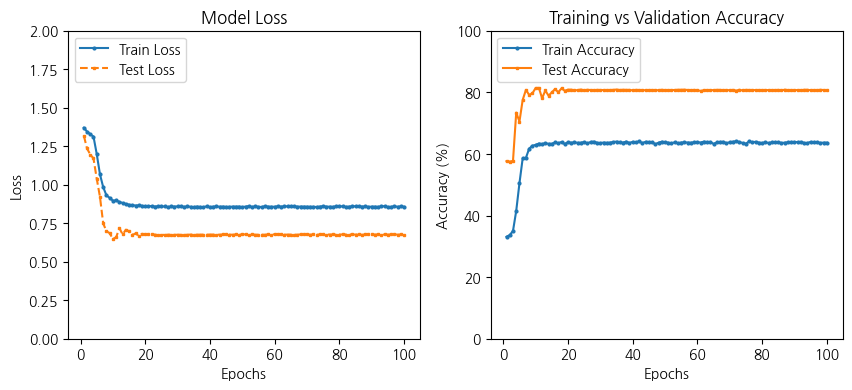


✅ 학습 및 검증 그래프 저장 완료 (/content/drive/MyDrive/DMS/data/model_results/031612_4s_sliding_yawsign_inversion2/train_results/training_results.png)



In [116]:
plot_train_test_results(
    epoch_train_losses,
    epoch_train_scores,
    epoch_test_losses,
    epoch_test_scores,
    save_path=config["train_result_path"],
)

### 마지막 학습률 확인

In [66]:
def get_current_lr(optimizer):
    return [param_group["lr"] for param_group in optimizer.param_groups]

current_lr = get_current_lr(optimizer)
print(f"🚀 현재 Learning Rate: {current_lr}")

NameError: name 'optimizer' is not defined

In [101]:
scheduler.get_last_lr()

[1.220703125e-08]

### confusion matrix 시각화

In [63]:
# 모델 로드 함수
def load_model(model, model_save_path, device):
    """저장된 모델을 불러오는 함수"""
    checkpoint = torch.load(model_save_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()
    print(f"✅ Model Loaded from {model_save_path}")
    return model

# Confusion Matrix 시각화 함수
def plot_confusion_matrix(y_true, y_pred):
    """
    Confusion Matrix를 그리는 함수
    """
    # 숫자 레이블을 글씨로 변환
    class_names = [label_mapping_inverse[i] for i in sorted(label_mapping_inverse.keys())]

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    print("\n🔹 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

# 학습 데이터에서 Confusion Matrix 계산
def evaluate_model(model, data_loader, class_names):
    """
    모델을 평가하고 Confusion Matrix를 출력하는 함수
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to("cuda"), y_batch.to("cuda")

            y_pred = model(x_batch)  # (batch_size, num_classes)
            y_pred_classes = torch.argmax(y_pred, dim=1)  # 가장 높은 확률을 가진 클래스를 예측값으로 선택

            all_preds.extend(y_pred_classes.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Confusion Matrix 출력
    plot_confusion_matrix(all_labels, all_preds)

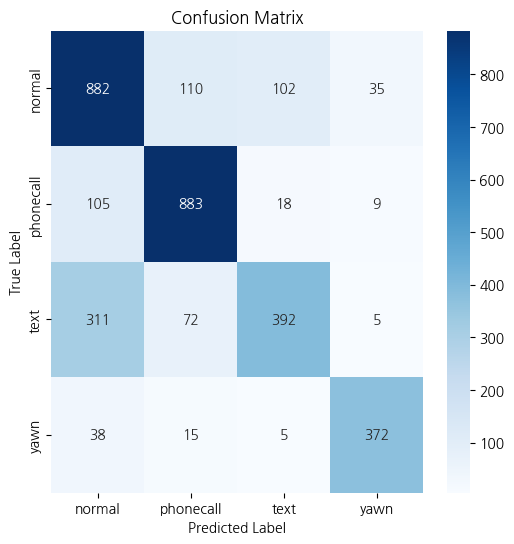


🔹 Classification Report:
              precision    recall  f1-score   support

      normal       0.66      0.78      0.72      1129
   phonecall       0.82      0.87      0.84      1015
        text       0.76      0.50      0.60       780
        yawn       0.88      0.87      0.87       430

    accuracy                           0.75      3354
   macro avg       0.78      0.75      0.76      3354
weighted avg       0.76      0.75      0.75      3354



In [69]:
# model = load_model(model, config["model_save_path"] +"/best_model_2025-03-16.pth", device)
class_names = config['action_names']
train_dataset_ = TensorDataset(train_features, train_labels)
train_loader_ = DataLoader(train_dataset_, **params)
evaluate_model(model, train_loader_, class_names)

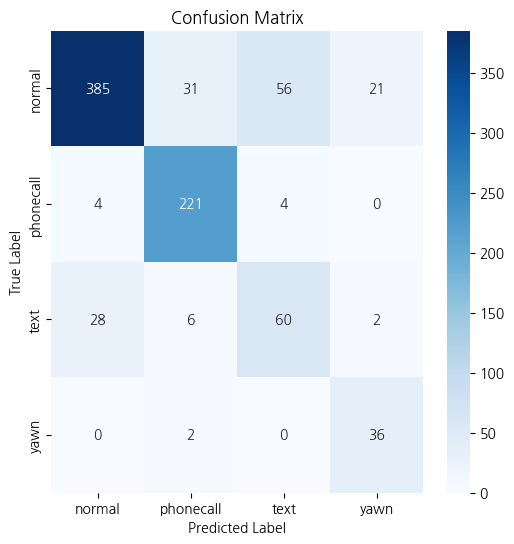


🔹 Classification Report:
              precision    recall  f1-score   support

      normal       0.92      0.78      0.85       493
   phonecall       0.85      0.97      0.90       229
        text       0.50      0.62      0.56        96
        yawn       0.61      0.95      0.74        38

    accuracy                           0.82       856
   macro avg       0.72      0.83      0.76       856
weighted avg       0.84      0.82      0.82       856



In [65]:
class_names = config['action_names']
evaluate_model(model, test_loader, class_names)

# 2. 테스트 코드
1. **동영상에서 프레임 추출**
2. **12개씩 프레임 묶음 (시퀀스 단위)**
3. **특징 추출 (Pitch, Yaw, EAR, MAR, Phone 사용 여부)**
4. **특징값 병합**
5. **LSTM Input 형식 변환**
6. **LSTM 모델 예측 (테스트 수행)**

In [ ]:
import os
import numpy as np

def merge_video_parts_to_24frames(data_dir, save_dir):
    """
    한 비디오의 여러 `part-*` 파일들을 순서대로 합쳐 24프레임씩 묶어 저장하는 함수.

    Args:
        data_dir (str): 기존 12프레임 묶음 데이터가 저장된 디렉토리.
        save_dir (str): 24프레임으로 변환된 데이터를 저장할 디렉토리.
    """
    os.makedirs(save_dir, exist_ok=True)  # 저장할 디렉토리 생성

    # ✅ 12프레임 묶음 파일 리스트 가져오기
    all_files = sorted(os.listdir(data_dir))  # 파일 이름 기준 정렬
    video_dict = {}

    # ✅ 비디오별로 `part-*`를 그룹화
    for file in all_files:
        if not file.endswith(".npz"):  # ✅ npz 파일이 아니면 스킵
            continue
        video_name, part = file.rsplit("_", 1)  # ✅ 비디오 이름과 `part-*` 분리
        video_dict.setdefault(video_name, []).append(file)

    # ✅ 각 비디오별로 `part-*`들을 24프레임 단위로 묶어서 저장
    for video_name, parts in video_dict.items():
        parts.sort()  # ✅ part 순서대로 정렬
        merged_features = []
        merged_labels = []
        part_count = 0

        for part_file in parts:
            part_data = np.load(os.path.join(data_dir, part_file), allow_pickle=True)

            # ✅ 기존 12프레임 데이터 추가
            merged_features.append(part_data["features"])
            merged_labels.append(part_data["labels"])

            # ✅ 24프레임이 채워졌을 경우 저장
            if len(merged_features) == 2:  # 12프레임 x 2 = 24프레임
                full_features = np.concatenate(merged_features, axis=0)
                full_labels = np.concatenate(merged_labels, axis=0)

                # ✅ 저장할 파일명 생성
                merged_file_name = f"{video_name}_merged-{part_count}.npz"
                save_path = os.path.join(save_dir, merged_file_name)

                # ✅ 데이터 저장
                np.savez_compressed(save_path, features=full_features, labels=full_labels)
                print(f"✅ Saved: {save_path}")

                # ✅ 초기화
                merged_features = []
                merged_labels = []
                part_count += 1

        # ✅ 남은 데이터(12프레임 미만)도 저장
        if merged_features:
            remaining_features = np.concatenate(merged_features, axis=0)
            remaining_labels = np.concatenate(merged_labels, axis=0)

            remaining_file_name = f"{video_name}_merged-{part_count}.npz"
            save_path = os.path.join(save_dir, remaining_file_name)
            np.savez_compressed(save_path, features=remaining_features, labels=remaining_labels)
            print(f"✅ Saved (Remaining): {save_path}")

    print("🎉 모든 비디오의 `part-*`를 24프레임 단위로 변환 완료!")

# ✅ 변환 실행 예제
data_dir = "/content/drive/MyDrive/DMS/12_frame_batches"
save_dir = "/content/drive/MyDrive/DMS/24_frame_batches"

merge_video_parts_to_24frames(data_dir, save_dir)


In [ ]:
train.head(50)

In [ ]:
train.video_name[23]

In [ ]:
train.video_name[24]

In [ ]:
video_names = train['video_name']
video_clip = []
parts = []
for video_name in video_names:
    splited = video_name.split('_')
    part = splited[-1][4:]
    parts.append(part)
    video_clip.append(''.join(splited[:-1]))
train['part'] = parts
train['video_clip'] = video_clip

In [ ]:
train.info()

In [ ]:
train[20:30]

In [ ]:
timestep = 24

grouped = train.groupby("video_clip")
sequences = []

for _, group in grouped:
    group = group.sort_values(by="frame")  # 프레임 순서 정렬
    features = group[["pitch", "yaw", "avg_EAR", "MAR"]].values
    labels = group["label"].values

    num_samples = len(features) // timestep  # 가능한 샘플 개수
    features = features[:num_samples * timestep]  # 24 프레임 단위로 자르기
    labels = labels[:num_samples * timestep]  # 라벨도 동일하게 자르기

    # (샘플 개수, 24, 특성 수) 형태로 변환
    features = features.reshape(num_samples, timestep, -1)


In [ ]:
sequences

In [ ]:
group

In [ ]:
features

In [ ]:
labels

In [ ]:
group